<a href="https://colab.research.google.com/github/vcorredorg/SenalesySistemas2025/blob/main/Taller2/Transformada_de_Laplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformada de Laplace

## **2.1 Convolución**

La convolución entre las señales se define como

$$
y(t) = (x * h)(t) = \int_{-\infty}^{\infty} x(\tau)\, h(t - \tau)\, d\tau
$$

En este ejercicio tomamos:

- $h(t) = e^{-t} u(t)$  (exponencial decreciente causal)
- $x(t) = \text{rect}\!\left(t - \tfrac{1}{2}\right)$, que equivale a un pulso de amplitud 1 en el intervalo $[0,1]$

Entonces:

- $x(\tau) = 1$ si $0 \le \tau \le 1$, y $0$ en otro caso  
- $h(t-\tau) = e^{-(t-\tau)} u(t-\tau)$, que es cero si $t-\tau < 0$, es decir, si $\ta


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

# Para que las animaciones se muestren como HTML (jshtml) en notebooks
rc("animation", html="jshtml")


# Definición de las señales x(t) y h(t)
def rect_pulso(t):
    """
    Aproximación de rect(t - 1/2), pulso de amplitud 1 en [0, 1].
    """
    return np.where((t >= 0) & (t <= 1), 1.0, 0.0)


def x(t):
    # x(t) = rect(t - 1/2), implementado como pulso en [0, 1]
    return rect_pulso(t)


def h(t):
    # h(t) = e^{-t} u(t)
    u = (t >= 0).astype(float)
    return np.exp(-t) * u


def y_analitica(t):
    """
    y(t) =
        0                   , t < 0
        1 - exp(-t)         , 0 <= t < 1
        (e - 1) * exp(-t)   , t >= 1
    """
    t = np.array(t)
    y = np.zeros_like(t)

    # Caso 2: 0 <= t < 1
    mask2 = (t >= 0) & (t < 1)
    y[mask2] = 1 - np.exp(-t[mask2])

    # Caso 3: t >= 1
    mask3 = t >= 1
    y[mask3] = (np.e - 1) * np.exp(-t[mask3])

    return y


# Mallas de tiempo para τ (tau) y t
dt = 0.02                   # PASO DE TIEMPO MÁS GRANDE:menos puntos
tau = np.arange(-2, 5, dt)  # eje de integración τ
t_vals = np.arange(-2, 5, dt)  # valores de t para la animación

x_tau = x(tau)

# Precomputamos la solución analítica en la misma malla de t
y_t_analitica = y_analitica(t_vals)

# Configuración de la figura para animación (un poco más pequeña también ayuda)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

# Subgráfica 1: x(τ) y h(t-τ) deslizándose
ax1.set_title("Convolución: deslizamiento de $h(t-\\tau)$ sobre $x(\\tau)$")
ax1.set_xlabel("$\\tau$")
ax1.set_ylabel("Amplitud")

line_x, = ax1.plot(tau, x_tau, label="$x(\\tau)$")
line_h, = ax1.plot([], [], label="$h(t-\\tau)$")  # se actualiza en cada frame

# Relleno para la región del producto x(τ)h(t-τ)
fill_product = None

ax1.legend()
ax1.grid(True)
ax1.set_xlim(tau[0], tau[-1])
ax1.set_ylim(-0.1, 1.2)  # rango razonable para ver bien el pulso y la expo

# Subgráfica 2: y(t) acumulándose
ax2.set_title("Resultado de la convolución $y(t)$")
ax2.set_xlabel("t")
ax2.set_ylabel("y(t)")
ax2.grid(True)
ax2.set_xlim(t_vals[0], t_vals[-1])

# Línea de y(t) numérica (que vamos construyendo) y analítica
line_y_num, = ax2.plot([], [], label="$y(t)$ numérica")
line_y_ana, = ax2.plot(t_vals, y_t_analitica, "--", label="$y(t)$ analítica")
ax2.legend()

# Arreglo para ir guardando el valor de la integral numérica en cada t
y_num = np.zeros_like(t_vals)


# Función que calcula la convolución numérica para un t dado
def convolucion_en_t(t_actual):
    """
    Aproxima y(t_actual) = ∫ x(τ) h(t_actual - τ) dτ con una suma discreta.
    """
    h_shift = h(t_actual - tau)  # h(t - τ)
    producto = x_tau * h_shift   # x(τ)*h(t-τ)
    # aproximación numérica de la integral:
    return np.sum(producto) * dt, h_shift, producto


# Funciones de inicialización y actualización de la animación
def init():
    global fill_product
    # Inicializamos las líneas y vaciamos el relleno
    line_h.set_data([], [])
    line_y_num.set_data([], [])
    if fill_product is not None:
        fill_product.remove()
        fill_product = None
    return line_h, line_y_num


def update(frame_idx):
    """
    frame_idx es un ÍNDICE de t_vals, no el número de frame consecutivo.
    Esto nos permite saltarnos puntos y tener menos frames.
    """
    global fill_product

    t_actual = t_vals[frame_idx]

    # Calculamos y(t) numérica y las señales desplazadas
    y_val, h_shift, producto = convolucion_en_t(t_actual)
    y_num[frame_idx] = y_val

    # Actualizamos h(t-τ)
    line_h.set_data(tau, h_shift)

    # Actualizamos el relleno de la región donde hay producto
    if fill_product is not None:
        fill_product.remove()  # quitamos el relleno anterior

    # Sólo rellenamos donde el producto no es prácticamente cero
    mask = producto > 1e-4
    if np.any(mask):
        fill_product = ax1.fill_between(
            tau[mask],
            0,
            producto[mask],
            alpha=0.3
        )
    else:
        fill_product = None

    # Actualizar y(t) numérica hasta el tiempo actual
    # (Los puntos intermedios que no han sido "visitados" quedan en 0,
    # pero visualmente la curva se ve suave con este dt.)
    line_y_num.set_data(t_vals[:frame_idx+1], y_num[:frame_idx+1])

    # Título dinámico con el valor de t
    ax1.set_title(
        f"Convolución: $h(t-\\tau)$ sobre $x(\\tau)$,   t = {t_actual:.2f}"
    )

    return line_h, line_y_num


# Definir los frames como un subconjunto de índices de t_vals (menos frames → animación más ligera)
frames_idx = list(range(0, len(t_vals), 5))  # usa 1 de cada 5 puntos de t

# Crear animación
anim = FuncAnimation(
    fig,
    update,
    frames=frames_idx,
    init_func=init,
    blit=False,
    interval=80
)

# Cerramos la figura estática para que no aparezca duplicada
plt.close(fig)

# En Colab/Jupyter: mostrar la animación dejando 'anim' como última línea
anim

---
## **2.2 Respuesta al impulso**

## Sistema LTI y EDO

Consideremos el sistema LTI descrito por la ecuación diferencial

$$
\frac{d}{dt} y(t) + y(t) = x(t),
$$

con condiciones iniciales nulas:

$$
y(t)\big\vert_{t=0^-} = 0.
$$

Tomamos la entrada

$$
x(t) = e^{-2t} u(t),
$$

donde $u(t)$ es la función de Heaviside (escalón unitario).  

El objetivo es:

1. Obtener $y(t)$ resolviendo la EDO.
2. Obtener $y(t)$ mediante la convolución $y(t) = x(t) * h(t)$.
3. Comparar ambas soluciones.
4. Verificar manualmente la respuesta al impulso $h(t)$ y la integral de convolución, usando las funciones de Heaviside.

###Solución de la EDO para $x(t) = e^{-2t}u(t)$

La EDO es

$$
\frac{d}{dt} y(t) + y(t) = e^{-2t} u(t).
$$

Para $t>0$, podemos trabajar con

$$
\frac{d}{dt} y(t) + y(t) = e^{-2t},
$$

y la condición inicial equivalente $y(0) = 0$ (por causalidad y CI nulas antes de $0$).

### Solución de la parte homogénea

La ecuación homogénea es

$$
\frac{d}{dt} y_h(t) + y_h(t) = 0.
$$

Su solución es

$$
y_h(t) = C e^{-t}.
$$

### Solución particular

Buscamos una solución particular del tipo

$$
y_p(t) = A e^{-2t}.
$$

Entonces

$$
\frac{d}{dt} y_p(t) = -2A e^{-2t},
$$

y al sustituir en la EDO:

$$
-2A e^{-2t} + A e^{-2t} = e^{-2t}.
$$

Esto implica

$$
- A e^{-2t} = e^{-2t} \quad \Rightarrow \quad -A = 1 \quad \Rightarrow \quad A = -1.
$$

Así,

$$
y_p(t) = - e^{-2t}.
$$

### Solución general y condición inicial

La solución general para $t>0$ es

$$
y(t) = y_h(t) + y_p(t) = C e^{-t} - e^{-2t}.
$$

Usamos $y(0) = 0$:

$$
y(0) = C e^{0} - e^{0} = C - 1 = 0 \quad \Rightarrow \quad C = 1.
$$

Por tanto, para $t>0$:

$$
y(t) = e^{-t} - e^{-2t}.
$$

Incluyendo la causalidad mediante $u(t)$:

$$
y_{\text{EDO}}(t) = \big( e^{-t} - e^{-2t} \big) \, u(t).
$$


### Respuesta al impulso $h(t)$ (cuando $x(t) = \delta(t)$)

Ahora consideramos el mismo sistema con entrada

$$
x(t) = \delta(t).
$$

La ecuación se convierte en

$$
\frac{d}{dt} h(t) + h(t) = \delta(t),
$$

donde $h(t)$ es la respuesta al impulso. Usamos que el sistema es **causal**, así que

$$
h(t) = 0 \quad \text{para } t < 0.
$$

### Solución para $t \neq 0$

Para $t \neq 0$, el lado derecho es cero (fuera del impulso), de modo que:

$$
\frac{d}{dt} h(t) + h(t) = 0.
$$

La solución es

$$
h(t) = K e^{-t}, \quad t > 0.
$$

Para $t<0$, por causalidad,

$$
h(t) = 0.
$$

Así, en forma general:

$$
h(t) = K e^{-t} u(t).
$$

###Condición de salto usando la delta de Dirac

Integramos la ecuación alrededor de $t=0$ en el intervalo $[-\varepsilon, \varepsilon]$:

$$
\int_{-\varepsilon}^{\varepsilon} \left( \frac{d}{dt} h(t) + h(t) \right) dt
= \int_{-\varepsilon}^{\varepsilon} \delta(t) \, dt.
$$

El lado derecho es

$$
\int_{-\varepsilon}^{\varepsilon} \delta(t)\, dt = 1.
$$

Para el lado izquierdo:

$$
\int_{-\varepsilon}^{\varepsilon} \frac{d}{dt} h(t)\, dt
= h(\varepsilon) - h(-\varepsilon) = h(0^+) - h(0^-).
$$

El término

$$
\int_{-\varepsilon}^{\varepsilon} h(t)\, dt
$$

tiende a cero cuando $\varepsilon \to 0$, porque el intervalo de integración se hace muy pequeño.

Entonces, en el límite:

$$
h(0^+) - h(0^-) = 1.
$$

Como $h(0^-) = 0$ (causalidad), se tiene

$$
h(0^+) = 1.
$$

Pero para $t>0$ teníamos $h(t) = K e^{-t}$, así que

$$
h(0^+) = K e^{0} = K = 1.
$$

Por lo tanto,

$$
h(t) = e^{-t} u(t).
$$

Esta respuesta al impulso es consistente con la idea de que

$$
\frac{d}{dt} u(t) = \delta(t).
$$

###Convolución: $y(t) = x(t) * h(t)$

Ahora tomamos

$$
x(t) = e^{-2t} u(t),
\qquad
h(t) = e^{-t} u(t).
$$

La salida del sistema por convolución es

$$
y(t) = (x * h)(t) = \int_{-\infty}^{\infty} x(\tau)\, h(t - \tau)\, d\tau.
$$

Como ambas señales son causales, el traslape sólo existe para $0 \le \tau \le t$, de modo que

$$
y(t) = \int_{0}^{t} e^{-2\tau} \, e^{-(t-\tau)}\, d\tau, \quad t \ge 0.
$$

Simplificamos el integrando:

$$
e^{-2\tau} \, e^{-(t-\tau)} = e^{-2\tau} \, e^{-t+\tau} = e^{-t} e^{-\tau}.
$$

Por tanto,

$$
y(t) = \int_{0}^{t} e^{-t} e^{-\tau} \, d\tau
= e^{-t} \int_{0}^{t} e^{-\tau} \, d\tau.
$$

Calculamos la integral:

$$
\int_{0}^{t} e^{-\tau} \, d\tau
= \left[ -e^{-\tau} \right]_{0}^{t}
= -e^{-t} + 1
= 1 - e^{-t}.
$$

Entonces:

$$
y(t) = e^{-t} \big( 1 - e^{-t} \big)
= e^{-t} - e^{-2t}, \quad t \ge 0.
$$

Incluyendo el escalón:

$$
y_{\text{conv}}(t) = \big( e^{-t} - e^{-2t} \big) u(t).
$$

###Comparación

De la EDO obtuvimos

$$
y_{\text{EDO}}(t) = \big( e^{-t} - e^{-2t} \big) u(t),
$$

y de la convolución obtuvimos

$$
y_{\text{conv}}(t) = \big( e^{-t} - e^{-2t} \big) u(t).
$$

Por lo tanto,

$$
y_{\text{EDO}}(t) = y_{\text{conv}}(t),
$$

es decir, **la solución obtenida resolviendo la EDO** y **la solución obtenida mediante la convolución** coinciden exactamente, como debe ocurrir en un sistema LTI con condiciones iniciales nulas.


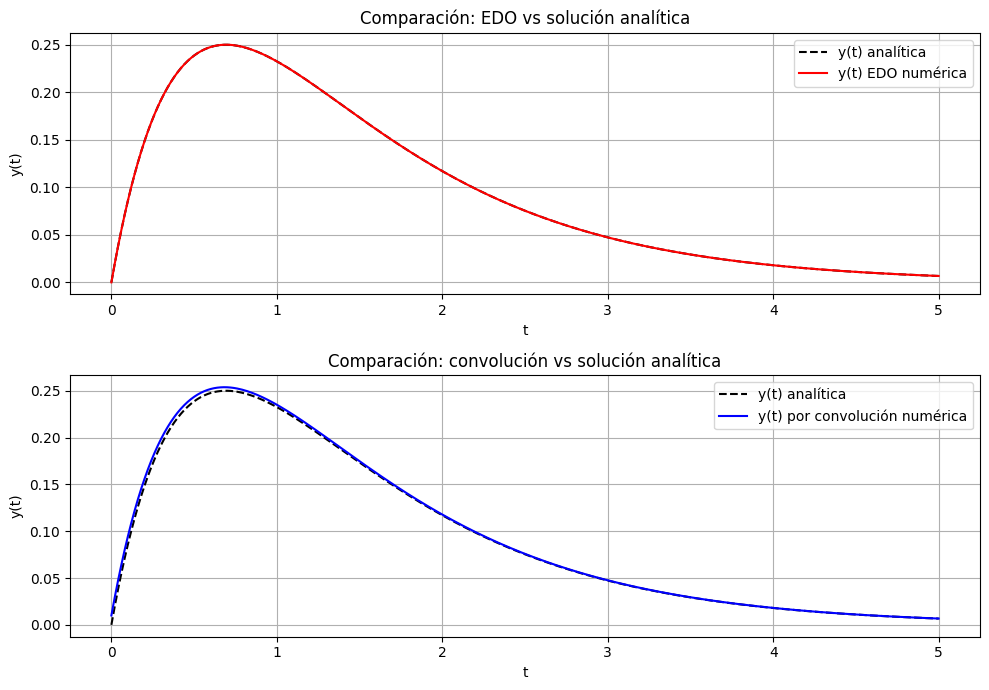

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definición de señales continuas aproximadas en tiempo discreto
def u(t):
    """Escalón unitario: funciona tanto para escalares como para vectores."""
    t_arr = np.asarray(t)
    return (t_arr >= 0).astype(float)

def x(t):
    """Entrada x(t) = e^{-2t} u(t)."""
    t_arr = np.asarray(t)
    return np.exp(-2 * t_arr) * u(t_arr)

def h(t):
    """Respuesta al impulso h(t) = e^{-t} u(t)."""
    t_arr = np.asarray(t)
    return np.exp(-t_arr) * u(t_arr)

def y_analitica(t):
    """Solución analítica: y(t) = (e^{-t} - e^{-2t}) u(t)."""
    t_arr = np.asarray(t)
    return (np.exp(-t_arr) - np.exp(-2 * t_arr)) * u(t_arr)


# 1) Solución numérica de la EDO: y'(t) + y(t) = x(t)
def ode(t, y):
    # solve_ivp pasa t como escalar y y como arreglo (aunque sea de tamaño 1)
    return x(t) - y   # y' = x(t) - y

t0, tf = 0.0, 5.0
y0 = [0.0]  # condición inicial y(0) = 0

sol = solve_ivp(
    ode,
    (t0, tf),
    y0,
    t_eval=np.linspace(t0, tf, 500)
)

t_ode = sol.t
y_ode = sol.y[0]


# 2) Salida por convolución numérica con h(t)
#    y_conv(t) ≈ dt * sum_k x(k) h(t-k)
dt = 0.01
t_conv = np.arange(0, 5 + dt, dt)

x_vals = x(t_conv)
h_vals = h(t_conv)

# Convolución discreta (aprox. continua)
y_conv_full = np.convolve(x_vals, h_vals) * dt

# El eje de tiempo de la convolución:
t_conv_full = np.arange(0, len(y_conv_full)) * dt

# Recortamos al mismo rango que [0, 5]
mask_conv = (t_conv_full >= 0) & (t_conv_full <= 5)
t_conv_plot = t_conv_full[mask_conv]
y_conv_plot = y_conv_full[mask_conv]

# 3) Solución analítica
t_ana = np.linspace(0, 5, 500)
y_ana = y_analitica(t_ana)


# 4) Gráficas
plt.figure(figsize=(10, 7))

# EDO vs analítica
plt.subplot(2, 1, 1)
plt.plot(t_ana, y_ana, 'k--', label='y(t) analítica')
plt.plot(t_ode, y_ode, 'r', label='y(t) EDO numérica')
plt.title("Comparación: EDO vs solución analítica")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.grid(True)
plt.legend()

# Convolución vs analítica
plt.subplot(2, 1, 2)
plt.plot(t_ana, y_ana, 'k--', label='y(t) analítica')
plt.plot(t_conv_plot, y_conv_plot, 'b', label='y(t) por convolución numérica')
plt.title("Comparación: convolución vs solución analítica")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


##**2.3 Demuestre si los siguientes sistemas de la forma y = H{x}, son sistemas lineales e invariantes en el tiempo (SLIT), además de presentar la simulación respectiva**

## Sistemas lineales e invariantes en el tiempo (SLIT)

A continuación se muestran las demostraciones matemáticas (paso a paso) de linealidad e invariancia en el tiempo para cada sistema.

Un sistema discreto se denota como

$$
y[n] = H\{x[n]\}.
$$

*Linealidad:*  
El sistema es lineal si, para cualesquiera señales $x_1[n], x_2[n]$ y escalares $a, b \in \mathbb{R}$,

$$
H\{a x_1[n] + b x_2[n]\} = a H\{x_1[n]\} + b H\{x_2[n]\}.
$$

*Invariancia en el tiempo:*
El sistema es invariante en el tiempo si, al desplazar la entrada, la salida se desplaza igual:

$$
x_2[n] = x_1[n-n_0] \quad \Rightarrow \quad H\{x_2[n]\} = y_2[n] = y_1[n-n_0].
$$

*(a)*

$$
y[n] = \frac{1}{3}x[n] + 2x[n-1] - y[n-1].
$$
*Linealidad:*

Sea el sistema

$$
H\{x[n]\} = y[n]
$$

definido por

$$
y[n] = \frac{1}{3}x[n] + 2x[n-1] - y[n-1].
$$

Supongamos que:

- $x_1[n] \to y_1[n]$, donde
  $$
  y_1[n] = \frac{1}{3}x_1[n] + 2x_1[n-1] - y_1[n-1].
  $$
- $x_2[n] \to y_2[n]$, donde
  $$
  y_2[n] = \frac{1}{3}x_2[n] + 2x_2[n-1] - y_2[n-1].
  $$

Tomemos una combinación lineal de entradas:

$$
x[n] = a x_1[n] + b x_2[n].
$$

Definimos

$$
y[n] = a y_1[n] + b y_2[n].
$$

Entonces:

$$
\begin{aligned}
y[n]
&= a y_1[n] + b y_2[n] \\
&= a\left(\frac{1}{3}x_1[n] + 2x_1[n-1] - y_1[n-1]\right)
 + b\left(\frac{1}{3}x_2[n] + 2x_2[n-1] - y_2[n-1]\right) \\
&= \frac{1}{3}\big(a x_1[n] + b x_2[n]\big)
 + 2\big(a x_1[n-1] + b x_2[n-1]\big)
 - \big(a y_1[n-1] + b y_2[n-1]\big) \\
&= \frac{1}{3}x[n] + 2x[n-1] - y[n-1].
\end{aligned}
$$

Esto muestra que la combinación lineal de soluciones también satisface la ecuación. Por tanto, el sistema es **lineal** (bajo condiciones iniciales en reposo).

*Invariancia en el tiempo*

Supongamos que a la entrada \(x[n]\) le corresponde la salida \(y[n]\) que satisface

$$
y[n] = \frac{1}{3}x[n] + 2x[n-1] - y[n-1].
$$

Ahora consideremos la entrada desplazada:

$$
x'[n] = x[n-n_0].
$$

La salida correspondiente \(y'[n]\) debe satisfacer

$$
y'[n] = \frac{1}{3}x'[n] + 2x'[n-1] - y'[n-1]
      = \frac{1}{3}x[n-n_0] + 2x[n-1-n_0] - y'[n-1].
$$

Proponemos:

$$
y'[n] = y[n-n_0].
$$

Entonces:

$$
\begin{aligned}
y'[n]
&= y[n-n_0] \\
&= \frac{1}{3}x[n-n_0] + 2x[n-1-n_0] - y[n-1-n_0] \\
&= \frac{1}{3}x[n-n_0] + 2x[n-1-n_0] - y'[n-1].
\end{aligned}
$$

Lo que coincide con la ecuación para $y'[n]$. Por tanto, el sistema es **invariante en el tiempo**.

**Conclusión para el sistema 1:** es un **SLIT** (sistema lineal e invariante en el tiempo).

---

*(b)*

Interpretamos el sistema como:

$$
y[n] = \sum_{k=-\infty}^{n} x^2[k].
$$

*Linealidad*

El sistema está definido por

$$
H\{x[n]\}[n] = \sum_{k=-\infty}^{n} x^2[k].
$$

Tomemos dos señales $x_1[n], x_2[n]$ y escalares \(a,b\). Entonces:

$$
\begin{aligned}
H\{a x_1[n] + b x_2[n]\}[n]
&= \sum_{k=-\infty}^{n} \big(a x_1[k] + b x_2[k]\big)^2 \\
&= \sum_{k=-\infty}^{n} \left( a^2 x_1^2[k] + 2ab x_1[k]x_2[k] + b^2 x_2^2[k] \right) \\
&= a^2 \sum_{k=-\infty}^{n} x_1^2[k]
 + 2ab \sum_{k=-\infty}^{n} x_1[k]x_2[k]
 + b^2 \sum_{k=-\infty}^{n} x_2^2[k].
\end{aligned}
$$

Mientras que

$$
\begin{aligned}
a H\{x_1[n]\}[n] + b H\{x_2[n]\}[n]
&= a \sum_{k=-\infty}^{n} x_1^2[k] + b \sum_{k=-\infty}^{n} x_2^2[k].
\end{aligned}
$$

En general,

$$
a^2 \neq a, \quad b^2 \neq b,
$$

y aparece el término cruzado $2ab \sum x_1[k]x_2[k]$.  
Por tanto, en general:

$$
H\{a x_1 + b x_2\}[n] \neq a H\{x_1\}[n] + b H\{x_2\}[n].
$$

Un contraejemplo concreto:

- Sea $x_1[n] = \delta[n]$, $x_2[n] = 0$, $a=2$.
- Entonces:
  $$
  H\{x_1\}[0] = \sum_{k=-\infty}^{0} \delta^2[k] = 1,
  $$
  $$
  H\{2x_1\}[0] = \sum_{k=-\infty}^{0} (2\delta[k])^2 = 4.
  $$

Si el sistema fuera lineal, debería cumplirse:

$$
H\{2x_1\}[0] = 2 H\{x_1\}[0] = 2,
$$

pero en realidad es 4. Luego el sistema es **no lineal**.

*Invariancia en el tiempo*

Sea la salida original

$$
y[n] = \sum_{k=-\infty}^{n} x^2[k].
$$

Ahora consideremos la entrada desplazada:

$$
x'[n] = x[n-n_0].
$$

La salida será

$$
\begin{aligned}
y'[n]
&= \sum_{k=-\infty}^{n} (x'[k])^2
= \sum_{k=-\infty}^{n} x^2[k-n_0].
\end{aligned}
$$

Hacemos el cambio de variable

$$
m = k - n_0 \quad \Rightarrow \quad k = m + n_0.
$$

Cuando \(k\) recorre $(-\infty, n]$, entonces \(m\) recorre $(-\infty, n-n_0]$. Por lo tanto,

$$
\begin{aligned}
y'[n]
&= \sum_{m=-\infty}^{n-n_0} x^2[m]
= y[n-n_0].
\end{aligned}
$$

Esto cumple exactamente la definición de invariancia en el tiempo:

$$
H\{x[n-n_0]\}[n] = y[n-n_0].
$$

**Conclusión para el sistema 2:** No es lineal, pero **sí es invariante en el tiempo**.

---
*(c)*

Tomamos el sistema como

$$
y[n] = \mathrm{median}\big(x[n-1], x[n], x[n+1]\big).
$$
*Linealidad*

La mediana selecciona el valor “del medio” de los tres, no es una operación lineal.

Buscamos un contraejemplo para la propiedad de aditividad:

$$
H\{x_1 + x_2\}[n] \stackrel{?}{=} H\{x_1\}[n] + H\{x_2\}[n].
$$

Tomemos, en una posición particular \(n\):

- $x_1$ tal que la ventana es
  $$
  (x_1[n-1], x_1[n], x_1[n+1]) = (0,0,10) \quad \Rightarrow \quad \mathrm{median} = 0.
  $$
  Por tanto, \(H\{x_1\}[n] = 0\).
- $x_2$ tal que la ventana es
  $$
  (x_2[n-1], x_2[n], x_2[n+1]) = (10,0,0) \quad \Rightarrow \quad \mathrm{median} = 0.
  $$
  Por tanto, \(H\{x_2\}[n] = 0\).

Ahora sumamos:

$$
x_3 = x_1 + x_2.
$$

La ventana en \(n\) será:

$$
(x_3[n-1], x_3[n], x_3[n+1]) = (10, 0, 10),
$$

cuya mediana es

$$
\mathrm{median}(10,0,10) = 10.
$$

Así,

$$
H\{x_3\}[n] = 10,
$$

mientras que

$$
H\{x_1\}[n] + H\{x_2\}[n] = 0 + 0 = 0.
$$

Por tanto

$$
H\{x_1 + x_2\}[n] \neq H\{x_1\}[n] + H\{x_2\}[n],
$$

y el sistema es **no lineal**.

(La homogeneidad $H\{a x\} = a H\{x\}$  también se rompe en general.)

*Invariancia en el tiempo*

La definición del sistema en cada \(n\) es

$$
y[n] = \mathrm{median}\big(x[n-1], x[n], x[n+1]\big).
$$

Tomemos una entrada \(x[n]\) con salida \(y[n]\). Ahora definimos la entrada desplazada:

$$
x'[n] = x[n-n_0].
$$

La salida será

$$
\begin{aligned}
y'[n]
&= \mathrm{median}\big(x'[n-1], x'[n], x'[n+1]\big) \\
&= \mathrm{median}\big(x[n-1-n_0], x[n-n_0], x[n+1-n_0]\big).
\end{aligned}
$$

Por otro lado, la salida original desplazada es

$$
y[n-n_0] = \mathrm{median}\big(x[n-1-n_0], x[n-n_0], x[n+1-n_0]\big).
$$

Luego

$$
y'[n] = y[n-n_0].
$$

Esto cumple la condición de invariancia en el tiempo.

**Conclusión para el sistema 3:** No es lineal, pero **sí es invariante en el tiempo**.

---
*(d)*

$$
y(t) = A x(t) + B, \quad A,B \in \mathbb{R}.
$$

*Linealidad*

El sistema es

$$
H\{x(t)\} = A x(t) + B.
$$

Primero, observemos la salida a la entrada cero \(x(t) \equiv 0\):

$$
H\{0\} = A \cdot 0 + B = B.
$$

Para que el sistema sea lineal, se requiere que a la entrada cero corresponda salida cero:

$$
x(t) \equiv 0 \quad \Rightarrow \quad y(t) \equiv 0.
$$

Esto sólo ocurre si

$$
B = 0.
$$

Otra manera es verificar homogeneidad: sea $a \in \mathbb{R}$,

$$
\begin{aligned}
H\{a x(t)\}
&= A (a x(t)) + B
= a A x(t) + B, \\
a H\{x(t)\}
&= a (A x(t) + B)
= a A x(t) + a B.
\end{aligned}
$$

Para que

$$
H\{a x(t)\} = a H\{x(t)\} \quad \forall a,x(t),
$$

se requiere

$$
B = aB \quad \forall a \quad \Rightarrow \quad B = 0.
$$

Por tanto:

- Si $B = 0$, el sistema se reduce a
  $$
  y(t) = A x(t),
  $$
  que es claramente lineal.
- Si $B \neq 0$, el sistema es **no lineal** (es un sistema afín).

*Invariancia en el tiempo*

Verificamos la invariancia en el tiempo. Sea

$$
y(t) = H\{x(t)\} = A x(t) + B.
$$

Ahora tomamos la entrada desplazada

$$
x_\tau(t) = x(t - t_0).
$$

La salida correspondiente será

$$
H\{x_\tau(t)\}
= A x(t - t_0) + B.
$$

Por otra parte, si desplazamos la salida original:

$$
y(t - t_0) = A x(t - t_0) + B.
$$

Por tanto:

$$
H\{x(t - t_0)\} = y(t - t_0),
$$

lo cual cumple la condición de invariancia en el tiempo, independientemente de los valores de \(A\) y \(B\).

**Conclusión para el sistema 4:**

- Si $B = 0$: el sistema es **lineal e invariante en el tiempo**.
- Si $B \neq 0$: el sistema es **no lineal**, pero **sí invariante en el tiempo**.

---


In [ ]:
import numpy as np

# Sistemas
def system1(x):
    """
    y[n] = x[n]/3 + 2 x[n-1] - y[n-1]
    Asumimos x[n] = 0 para n<0 y y[-1] = 0
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    for n in range(N):
        xn   = x[n]
        xnm1 = x[n-1] if n-1 >= 0 else 0.0
        ynm1 = y[n-1] if n-1 >= 0 else 0.0
        y[n] = xn/3.0 + 2.0*xnm1 - ynm1
    return y

def system2(x):
    """
    y[n] = sum_{k=-∞}^{n} x^2[k]
    En práctica: sumamos desde k=0 hasta n,
    asumiendo x[k]=0 para k<0.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    acc = 0.0
    for n in range(N):
        acc += x[n]**2
        y[n] = acc
    return y

def system3(x):
    """
    y[n] = median(x[n-1], x[n], x[n+1])
    Usamos padding con 0 en los bordes.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    for n in range(N):
        xnm1 = x[n-1] if n-1 >= 0 else 0.0
        xn   = x[n]
        xnp1 = x[n+1] if n+1 < N else 0.0
        y[n] = np.median([xnm1, xn, xnp1])
    return y

def system4(x, A=2.0, B=1.0):
    """
    y(t) = A x(t) + B
    Aquí lo simulamos en tiempo discreto: y[n] = A x[n] + B.
    """
    x = np.asarray(x, dtype=float)
    return A*x + B


# Utilidades para probar linealidad e invariancia en el tiempo
def test_linearity(system, N=20, A=1.5, B=-0.7, extra_kwargs=None):
    """
    Comprueba numéricamente H{A x1 + B x2} ≈ A H{x1} + B H{x2}.
    Devuelve el error máximo absoluto.
    """
    if extra_kwargs is None:
        extra_kwargs = {}

    x1 = np.random.randn(N)
    x2 = np.random.randn(N)

    left  = system(A*x1 + B*x2, **extra_kwargs)
    right = A*system(x1, **extra_kwargs) + B*system(x2, **extra_kwargs)

    err = np.max(np.abs(left - right))
    return err

def test_time_invariance(system, N=20, shift=3, extra_kwargs=None):
    """
    Comprueba numéricamente H{x[n-n0]} ≈ y[n-n0].
    Devuelve el error máximo absoluto.
    """
    if extra_kwargs is None:
        extra_kwargs = {}

    x = np.random.randn(N)

    # Señal desplazada: ponemos ceros al inicio
    x_shift = np.concatenate([np.zeros(shift), x])

    y      = system(x, **extra_kwargs)
    y_from_shifted_input = system(x_shift, **extra_kwargs)

    # Salida esperada si fuera invariante: misma y, pero desplazada
    y_shift_expected = np.concatenate([np.zeros(shift), y])

    L = min(len(y_from_shifted_input), len(y_shift_expected))
    err = np.max(np.abs(y_from_shifted_input[:L] - y_shift_expected[:L]))
    return err


# Pruebas
np.random.seed(0)  # para reproducibilidad

print("===== Sistema 1: y[n] = x[n]/3 + 2x[n-1] - y[n-1] =====")
err_lin_1 = test_linearity(system1)
err_ti_1  = test_time_invariance(system1)
print(f"Error de linealidad: {err_lin_1:.3e}")
print(f"Error de invariancia en el tiempo: {err_ti_1:.3e}\n")

print("===== Sistema 2: y[n] = sum x^2[k] =====")
err_lin_2 = test_linearity(system2)
err_ti_2  = test_time_invariance(system2)
print(f"Error de linealidad: {err_lin_2:.3e}")
print(f"Error de invariancia en el tiempo: {err_ti_2:.3e}\n")

print("===== Sistema 3: y[n] = median(x[n-1], x[n], x[n+1]) =====")
err_lin_3 = test_linearity(system3)
err_ti_3  = test_time_invariance(system3)
print(f"Error de linealidad: {err_lin_3:.3e}")
print(f"Error de invariancia en el tiempo: {err_ti_3:.3e}\n")

print("===== Sistema 4: y[n] = A x[n] + B, con A=2, B=1 =====")
err_lin_4 = test_linearity(system4, extra_kwargs={'A':2.0, 'B':1.0})
err_ti_4  = test_time_invariance(system4, extra_kwargs={'A':2.0, 'B':1.0})
print(f"Error de linealidad: {err_lin_4:.3e}")
print(f"Error de invariancia en el tiempo: {err_ti_4:.3e}\n")

print("===== Sistema 4 con B=0 (sólo para ver caso lineal) =====")
err_lin_4b = test_linearity(system4, extra_kwargs={'A':2.0, 'B':0.0})
err_ti_4b  = test_time_invariance(system4, extra_kwargs={'A':2.0, 'B':0.0})
print(f"Error de linealidad: {err_lin_4b:.3e}")
print(f"Error de invariancia en el tiempo: {err_ti_4b:.3e}")


===== Sistema 1: y[n] = x[n]/3 + 2x[n-1] - y[n-1] =====
Error de linealidad: 3.109e-15
Error de invariancia en el tiempo: 0.000e+00

===== Sistema 2: y[n] = sum x^2[k] =====
Error de linealidad: 3.745e+01
Error de invariancia en el tiempo: 0.000e+00

===== Sistema 3: y[n] = median(x[n-1], x[n], x[n+1]) =====
Error de linealidad: 1.049e+00
Error de invariancia en el tiempo: 0.000e+00

===== Sistema 4: y[n] = A x[n] + B, con A=2, B=1 =====
Error de linealidad: 2.000e-01
Error de invariancia en el tiempo: 1.000e+00

===== Sistema 4 con B=0 (sólo para ver caso lineal) =====
Error de linealidad: 0.000e+00
Error de invariancia en el tiempo: 0.000e+00


####Gráficas

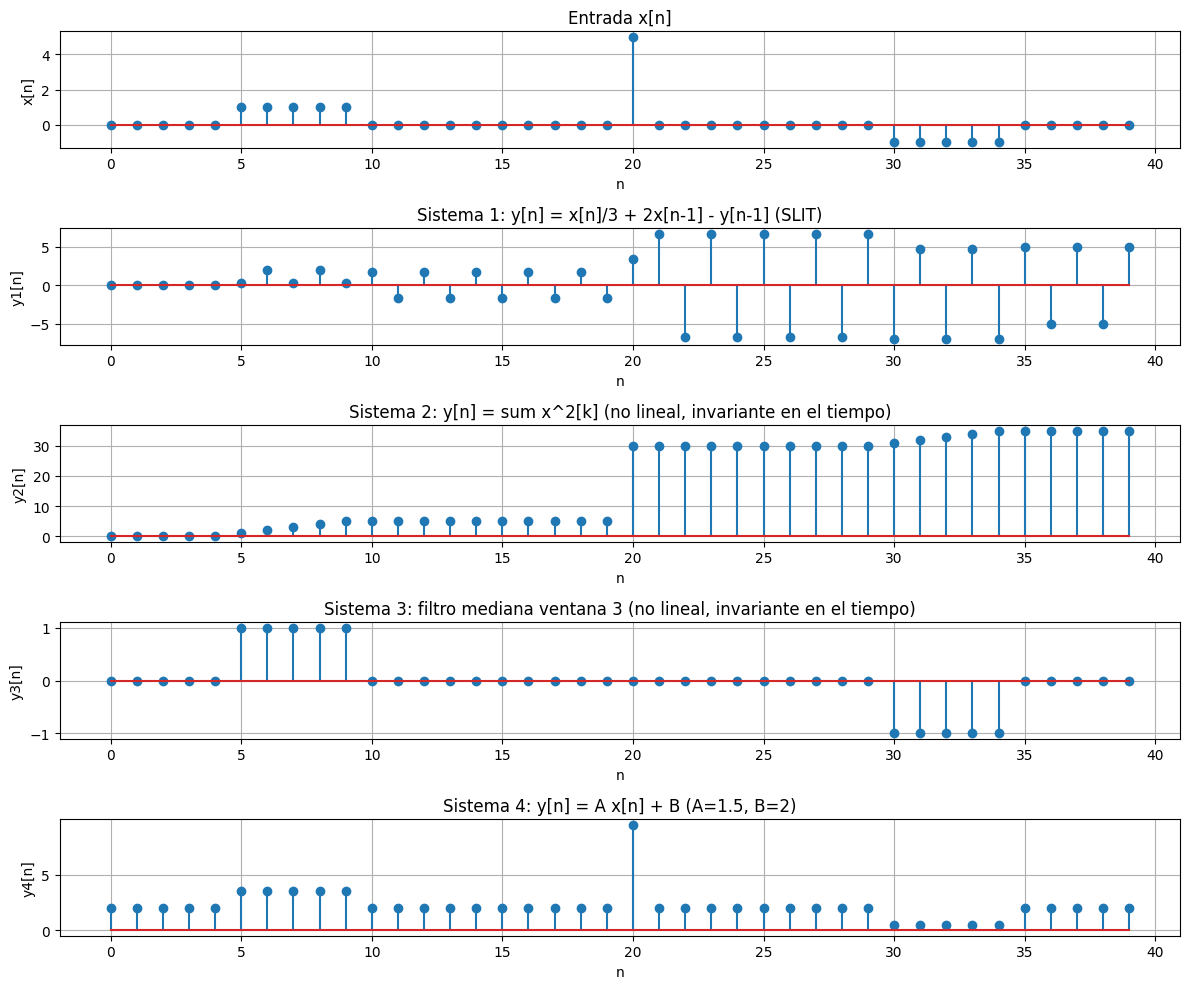

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de los sistemas
def system1(x):
    """
    Sistema 1:
    y[n] = x[n]/3 + 2 x[n-1] - y[n-1]
    Asumimos x[n] = 0 para n < 0 y y[-1] = 0.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    for n in range(N):
        xn   = x[n]
        xnm1 = x[n-1] if n-1 >= 0 else 0.0
        ynm1 = y[n-1] if n-1 >= 0 else 0.0
        y[n] = xn/3.0 + 2.0*xnm1 - ynm1
    return y

def system2(x):
    """
    Sistema 2:
    y[n] = sum_{k=-∞}^{n} x^2[k]
    En práctica: sumamos desde k=0 hasta n,
    asumiendo x[k] = 0 para k < 0.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    acc = 0.0
    for n in range(N):
        acc += x[n]**2
        y[n] = acc
    return y

def system3(x):
    """
    Sistema 3:
    y[n] = median(x[n-1], x[n], x[n+1])
    Usamos padding con 0 en los bordes.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    y = np.zeros_like(x, dtype=float)
    for n in range(N):
        xnm1 = x[n-1] if n-1 >= 0 else 0.0
        xn   = x[n]
        xnp1 = x[n+1] if n+1 < N else 0.0
        y[n] = np.median([xnm1, xn, xnp1])
    return y

def system4(x, A=1.5, B=2.0):
    """
    Sistema 4:
    y[n] = A x[n] + B
    (simulación discreta de y(t) = A x(t) + B).
    """
    x = np.asarray(x, dtype=float)
    return A*x + B


# Señal de entrada de prueba
N = 40
n = np.arange(N)

x = np.zeros(N)
# Pulso entre n=5 y n=10
x[5:10] = 1.0
# Pico grande en n=20 (para que se note el efecto del filtro mediana)
x[20] = 5.0
# Otro pulso negativo
x[30:35] = -1.0


# Salidas de los sistemas
y1 = system1(x)
y2 = system2(x)
y3 = system3(x)
y4 = system4(x, A=1.5, B=2.0)


# Gráficas
plt.figure(figsize=(12, 10))

# Entrada
plt.subplot(5, 1, 1)
plt.stem(n, x)
plt.title("Entrada x[n]")
plt.xlabel("n")
plt.ylabel("x[n]")
plt.grid(True)

# Sistema 1 (SLIT)
plt.subplot(5, 1, 2)
plt.stem(n, y1)
plt.title("Sistema 1: y[n] = x[n]/3 + 2x[n-1] - y[n-1] (SLIT)")
plt.xlabel("n")
plt.ylabel("y1[n]")
plt.grid(True)

# Sistema 2 (no lineal, TI)
plt.subplot(5, 1, 3)
plt.stem(n, y2)
plt.title("Sistema 2: y[n] = sum x^2[k] (no lineal, invariante en el tiempo)")
plt.xlabel("n")
plt.ylabel("y2[n]")
plt.grid(True)

# Sistema 3 (mediana, no lineal, TI)
plt.subplot(5, 1, 4)
plt.stem(n, y3)
plt.title("Sistema 3: filtro mediana ventana 3 (no lineal, invariante en el tiempo)")
plt.xlabel("n")
plt.ylabel("y3[n]")
plt.grid(True)

# Sistema 4 (afín, TI, sólo lineal si B=0)
plt.subplot(5, 1, 5)
plt.stem(n, y4)
plt.title("Sistema 4: y[n] = A x[n] + B (A=1.5, B=2)")
plt.xlabel("n")
plt.ylabel("y4[n]")
plt.grid(True)

plt.tight_layout()
plt.show()


---
###**2.4 Hallar la salida y[n] de un SLIT ante la entrada x[n]={−15,5,−3†,0,5,7,−1}, con respuesta al impulso h[n]={1,−2,0†,1,−2}, donde n∈{0,±1,±2,...,±N} y n=0 para x[n]†. Nota: Utilizar método gráfico para encontrar la salida y comprobar con simulación en Python. Repita el proceso para el sistema con respuesta al escalón {−1,6,−10,3†,1,−10,2,5}**


 #### Convolución de $x[n]$ con $h[n]$ y con respuesta al escalón

####Definición de las señales

Se da la entrada

$$
x[n] = \{-15,\;5,\;-3^\dagger,\;0,\;5,\;7,\;-1\},
$$

donde la muestra marcada con $\dagger$ corresponde a $n=0$.  
Como hay 7 muestras y la tercera es $n=0$, tenemos:

- índice interno $k = 0,1,2,3,4,5,6$
- $k=2 \leftrightarrow n=0 \;\Rightarrow\; n = k - 2$

Por lo tanto:

$$
\begin{aligned}
x[-2] &= -15, \\
x[-1] &= 5, \\
x[0]  &= -3, \\
x[1]  &= 0, \\
x[2]  &= 5, \\
x[3]  &= 7, \\
x[4]  &= -1,
\end{aligned}
$$

y $x[n]=0$ fuera de este rango.

La respuesta al impulso del sistema es

$$
h[n] = \{1,\;-2,\;0^\dagger,\;1,\;-2\},
$$

donde la tercera muestra es $n=0$. De nuevo:

- índice interno $k = 0,1,2,3,4$  
- $k=2 \leftrightarrow n=0 \;\Rightarrow\; n = k - 2$

Entonces:

$$
\begin{aligned}
h[-2] &= 1, \\
h[-1] &= -2, \\
h[0]  &= 0, \\
h[1]  &= 1, \\
h[2]  &= -2,
\end{aligned}
$$

y $h[n]=0$ fuera de este rango.

####Convolución $y[n] = x[n] * h[n]$

Por definición:

$$
y[n] = (x * h)[n] = \sum_{k=-\infty}^{\infty} x[k]\, h[n-k].
$$

Como $x[n]$ es distinta de cero sólo para $n \in [-2,4]$ y $h[n]$ sólo para $n \in [-2,2]$,  
el soporte de $y[n]$ será:

$$
n_{\min} = -2 + (-2) = -4, \qquad
n_{\max} = 4 + 2 = 6,
$$

es decir, $y[n] \neq 0$ sólo para $n=-4,-3,-2,-1,0,1,2,3,4,5,6$.

El **método gráfico** consiste en voltear $h[k]$ para obtener $h[-k]$, desplazarla para formar $h[n-k]$ y, para cada $n$, sumar los productos donde hay traslape con $x[k]$.  
Aquí se muestra el mismo procedimiento en forma de sumas explícitas.

####Cálculo muestra a muestra

Para cada $n$, se listan los términos no nulos de la suma:

**Para $n=-4$:**

Sólo se traslapan $x[-2]$ y $h[-2]$:

$$
y[-4] = x[-2]\,h[-2] = (-15)(1) = -15.
$$

---

**Para $n=-3$:**

Traslapes: $(x[-1],h[-2])$ y $(x[-2],h[-1])$:

$$
\begin{aligned}
y[-3] &= x[-1]h[-2] + x[-2]h[-1] \\
      &= 5 \cdot 1 + (-15)\cdot(-2) \\
      &= 5 + 30 = 35.
\end{aligned}
$$

---

**Para $n=-2$:**

Traslapes: $(x[0],h[-2])$, $(x[-1],h[-1])$, $(x[-2],h[0])$:

$$
\begin{aligned}
y[-2] &= x[0]h[-2] + x[-1]h[-1] + x[-2]h[0] \\
      &= (-3)\cdot 1 + 5\cdot(-2) + (-15)\cdot 0 \\
      &= -3 - 10 + 0 = -13.
\end{aligned}
$$

---

**Para $n=-1$:**

Traslapes: $(x[1],h[-2])$, $(x[0],h[-1])$, $(x[-1],h[0])$, $(x[-2],h[1])$:

$$
\begin{aligned}
y[-1] &= x[1]h[-2] + x[0]h[-1] + x[-1]h[0] + x[-2]h[1] \\
      &= 0\cdot 1 + (-3)\cdot(-2) + 5\cdot 0 + (-15)\cdot 1 \\
      &= 0 + 6 + 0 - 15 = -9.
\end{aligned}
$$

---

**Para $n=0$:**

Traslapes: $(x[2],h[-2])$, $(x[1],h[-1])$, $(x[0],h[0])$, $(x[-1],h[1])$, $(x[-2],h[2])$:

$$
\begin{aligned}
y[0] &= x[2]h[-2] + x[1]h[-1] + x[0]h[0] + x[-1]h[1] + x[-2]h[2] \\
     &= 5\cdot 1 + 0\cdot(-2) + (-3)\cdot 0 + 5\cdot 1 + (-15)\cdot(-2) \\
     &= 5 + 0 + 0 + 5 + 30 = 40.
\end{aligned}
$$

---

**Para $n=1$:**

Traslapes: $(x[3],h[-2])$, $(x[2],h[-1])$, $(x[1],h[0])$, $(x[0],h[1])$, $(x[-1],h[2])$:

$$
\begin{aligned}
y[1] &= x[3]h[-2] + x[2]h[-1] + x[1]h[0] + x[0]h[1] + x[-1]h[2] \\
     &= 7\cdot 1 + 5\cdot(-2) + 0\cdot 0 + (-3)\cdot 1 + 5\cdot(-2) \\
     &= 7 - 10 + 0 - 3 - 10 = -16.
\end{aligned}
$$

---

**Para $n=2$:**

Traslapes: $(x[4],h[-2])$, $(x[3],h[-1])$, $(x[2],h[0])$, $(x[1],h[1])$, $(x[0],h[2])$:

$$
\begin{aligned}
y[2] &= x[4]h[-2] + x[3]h[-1] + x[2]h[0] + x[1]h[1] + x[0]h[2] \\
     &= (-1)\cdot 1 + 7\cdot(-2) + 5\cdot 0 + 0\cdot 1 + (-3)\cdot(-2) \\
     &= -1 - 14 + 0 + 0 + 6 = -9.
\end{aligned}
$$

---

**Para $n=3$:**

Traslapes: $(x[4],h[-1])$, $(x[3],h[0])$, $(x[2],h[1])$, $(x[1],h[2])$:

$$
\begin{aligned}
y[3] &= x[4]h[-1] + x[3]h[0] + x[2]h[1] + x[1]h[2] \\
     &= (-1)\cdot(-2) + 7\cdot 0 + 5\cdot 1 + 0\cdot(-2) \\
     &= 2 + 0 + 5 + 0 = 7.
\end{aligned}
$$

---

**Para $n=4$:**

Traslapes: $(x[4],h[0])$, $(x[3],h[1])$, $(x[2],h[2])$:

$$
\begin{aligned}
y[4] &= x[4]h[0] + x[3]h[1] + x[2]h[2] \\
     &= (-1)\cdot 0 + 7\cdot 1 + 5\cdot(-2) \\
     &= 0 + 7 - 10 = -3.
\end{aligned}
$$

---

**Para $n=5$:**

Traslapes: $(x[4],h[1])$, $(x[3],h[2])$:

$$
\begin{aligned}
y[5] &= x[4]h[1] + x[3]h[2] \\
     &= (-1)\cdot 1 + 7\cdot(-2) \\
     &= -1 - 14 = -15.
\end{aligned}
$$

---

**Para $n=6$:**

Sólo $(x[4],h[2])$:

$$
y[6] = x[4]h[2] = (-1)\cdot(-2) = 2.
$$

####Resultado final de $y[n]$ (primer sistema)

Resumiendo:

$$
\begin{aligned}
y[-4] &= -15, \\
y[-3] &= 35, \\
y[-2] &= -13, \\
y[-1] &= -9, \\
y[0]  &= 40, \\
y[1]  &= -16, \\
y[2]  &= -9, \\
y[3]  &= 7, \\
y[4]  &= -3, \\
y[5]  &= -15, \\
y[6]  &= 2.
\end{aligned}
$$

En forma compacta, indicando la muestra $n=0$:

$$
y[n] = \{-15,\;35,\;-13,\;-9,\;40^\dagger,\;-16,\;-9,\;7,\;-3,\;-15,\;2\}.
$$

---

####Sistema con **respuesta al escalón**

Ahora te dan la respuesta al escalón (no al impulso):

$$
s[n] = \{-1,\;6,\;-10,\;3^\dagger,\;1,\;-10,\;2,\;5\}.
$$

La muestra marcada con $\dagger$ corresponde a $n=0$.  
La longitud es 8, con:

- índice interno $k = 0,\dots,7$
- $k=3 \leftrightarrow n=0 \;\Rightarrow\; n = k - 3$

Por tanto:

$$
\begin{aligned}
s[-3] &= -1, \\
s[-2] &= 6, \\
s[-1] &= -10, \\
s[0]  &= 3, \\
s[1]  &= 1, \\
s[2]  &= -10, \\
s[3]  &= 2, \\
s[4]  &= 5,
\end{aligned}
$$

y $s[n]=0$ fuera de este rango.


#### De respuesta al escalón a respuesta al impulso

En un sistema LTI discreto:

- Respuesta al impulso: $h[n]$  
- Respuesta al escalón:  
  $$
  s[n] = \sum_{k=-\infty}^{n} h[k].
  $$

Entonces:

$$
h[n] = s[n] - s[n-1].
$$

Aplicamos esto para obtener la nueva respuesta al impulso $h_2[n]$ del segundo sistema, extendiendo $s[n]=0$ cuando el índice esté fuera de $\{-3,\dots,4\}$:

- Para $n=-3$:
  $$
  h_2[-3] = s[-3] - s[-4] = -1 - 0 = -1.
  $$
- Para $n=-2$:
  $$
  h_2[-2] = s[-2] - s[-3] = 6 - (-1) = 7.
  $$
- Para $n=-1$:
  $$
  h_2[-1] = s[-1] - s[-2] = -10 - 6 = -16.
  $$
- Para $n=0$:
  $$
  h_2[0] = s[0] - s[-1] = 3 - (-10) = 13.
  $$
- Para $n=1$:
  $$
  h_2[1] = s[1] - s[0] = 1 - 3 = -2.
  $$
- Para $n=2$:
  $$
  h_2[2] = s[2] - s[1] = -10 - 1 = -11.
  $$
- Para $n=3$:
  $$
  h_2[3] = s[3] - s[2] = 2 - (-10) = 12.
  $$
- Para $n=4$:
  $$
  h_2[4] = s[4] - s[3] = 5 - 2 = 3.
  $$
- Para $n=5$ (ahora $s[5]=0$, $s[4]=5$):
  $$
  h_2[5] = s[5] - s[4] = 0 - 5 = -5.
  $$

Por tanto:

$$
h_2[n] = \{-1,\;7,\;-16,\;13^\dagger,\;-2,\;-11,\;12,\;3,\;-5\},
$$

donde $13^\dagger$ es la muestra en $n=0$; es decir, $n$ va de $-3$ a $5$.


####Convolución del mismo $x[n]$ con $h_2[n]$

La salida del segundo sistema ante la misma entrada $x[n]$ es:

$$
y_2[n] = (x * h_2)[n] = \sum_{k=-\infty}^{\infty} x[k]\, h_2[n-k].
$$

Los soportes son:

- $x[n]$: de $-2$ a $4$  
- $h_2[n]$: de $-3$ a $5$

Entonces el soporte de $y_2[n]$ será:

$$
n_{\min} = -2 + (-3) = -5, \qquad
n_{\max} = 4 + 5 = 9.
$$

Repitiendo el mismo método de convolución (gráfico/tablas) se obtiene:

$$
\begin{aligned}
y_2[-5] &= 15, \\
y_2[-4] &= -110, \\
y_2[-3] &= 278, \\
y_2[-2] &= -296, \\
y_2[-1] &= 138, \\
y_2[0]  &= 144, \\
y_2[1]  &= -259, \\
y_2[2]  &= -6, \\
y_2[3]  &= 151, \\
y_2[4]  &= -116, \\
y_2[5]  &= 0, \\
y_2[6]  &= 110, \\
y_2[7]  &= -16, \\
y_2[8]  &= -38, \\
y_2[9]  &= 5.
\end{aligned}
$$

En forma de lista (primera muestra en $n=-5$):

$$
y_2[n] = \{15,\;-110,\;278,\;-296,\;138,\;144,\;-259,\;-6,\;151,\;-116,\;0,\;110,\;-16,\;-38,\;5\}.
$$

Estas expresiones se pueden comprobar fácilmente con una simulación en Python usando la función de convolución discreta.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x[n]
x_vals = np.array([-15, 5, -3, 0, 5, 7, -1], dtype=float)
n_x = np.arange(-2, 5)  # -2..4

# h[n] del primer sistema
h_vals = np.array([1, -2, 0, 1, -2], dtype=float)
n_h = np.arange(-2, 3)  # -2..2

# Convolución 1
y1 = np.convolve(x_vals, h_vals)
n_y1 = np.arange(n_x[0] + n_h[0], n_x[-1] + n_h[-1] + 1)

print("y1[n] (primer sistema):")
for ni, yi in zip(n_y1, y1):
    print(f"n = {ni:2d}, y1[n] = {yi:6.1f}")

#respuesta al escalón del segundo sistema
s_vals = np.array([-1, 6, -10, 3, 1, -10, 2, 5], dtype=float)
n_s = np.arange(-3, 5)  # -3..4

# h2[n] = s[n] - s[n-1]
def s_ext(n):
    # extensión con ceros
    if n < n_s[0] or n > n_s[-1]:
        return 0.0
    return s_vals[n - n_s[0]]

n_h2 = np.arange(-3, 6)  # -3..5
h2_vals = np.array([s_ext(n) - s_ext(n - 1) for n in n_h2])

print("\nh2[n] (respuesta al impulso del 2º sistema):")
for ni, hi in zip(n_h2, h2_vals):
    print(f"n = {ni:2d}, h2[n] = {hi:6.1f}")

# Convolución 2
y2 = np.convolve(x_vals, h2_vals)
n_y2 = np.arange(n_x[0] + n_h2[0], n_x[-1] + n_h2[-1] + 1)

print("\ny2[n] (segundo sistema, obtenido desde respuesta al escalón):")
for ni, yi in zip(n_y2, y2):
    print(f"n = {ni:2d}, y2[n] = {yi:6.1f}")


y1[n] (primer sistema):
n = -4, y1[n] =  -15.0
n = -3, y1[n] =   35.0
n = -2, y1[n] =  -13.0
n = -1, y1[n] =   -9.0
n =  0, y1[n] =   40.0
n =  1, y1[n] =  -16.0
n =  2, y1[n] =   -9.0
n =  3, y1[n] =    7.0
n =  4, y1[n] =   -3.0
n =  5, y1[n] =  -15.0
n =  6, y1[n] =    2.0

h2[n] (respuesta al impulso del 2º sistema):
n = -3, h2[n] =   -1.0
n = -2, h2[n] =    7.0
n = -1, h2[n] =  -16.0
n =  0, h2[n] =   13.0
n =  1, h2[n] =   -2.0
n =  2, h2[n] =  -11.0
n =  3, h2[n] =   12.0
n =  4, h2[n] =    3.0
n =  5, h2[n] =   -5.0

y2[n] (segundo sistema, obtenido desde respuesta al escalón):
n = -5, y2[n] =   15.0
n = -4, y2[n] = -110.0
n = -3, y2[n] =  278.0
n = -2, y2[n] = -296.0
n = -1, y2[n] =  138.0
n =  0, y2[n] =  144.0
n =  1, y2[n] = -259.0
n =  2, y2[n] =   -6.0
n =  3, y2[n] =  151.0
n =  4, y2[n] = -116.0
n =  5, y2[n] =    0.0
n =  6, y2[n] =  110.0
n =  7, y2[n] =  -16.0
n =  8, y2[n] =  -38.0
n =  9, y2[n] =    5.0


###Gráficas

$x[n]$, $h[n]$ y $y_1[n]=x*h$

y1[n] (primer sistema):
n = -4, y1[n] =  -15.0
n = -3, y1[n] =   35.0
n = -2, y1[n] =  -13.0
n = -1, y1[n] =   -9.0
n =  0, y1[n] =   40.0
n =  1, y1[n] =  -16.0
n =  2, y1[n] =   -9.0
n =  3, y1[n] =    7.0
n =  4, y1[n] =   -3.0
n =  5, y1[n] =  -15.0
n =  6, y1[n] =    2.0


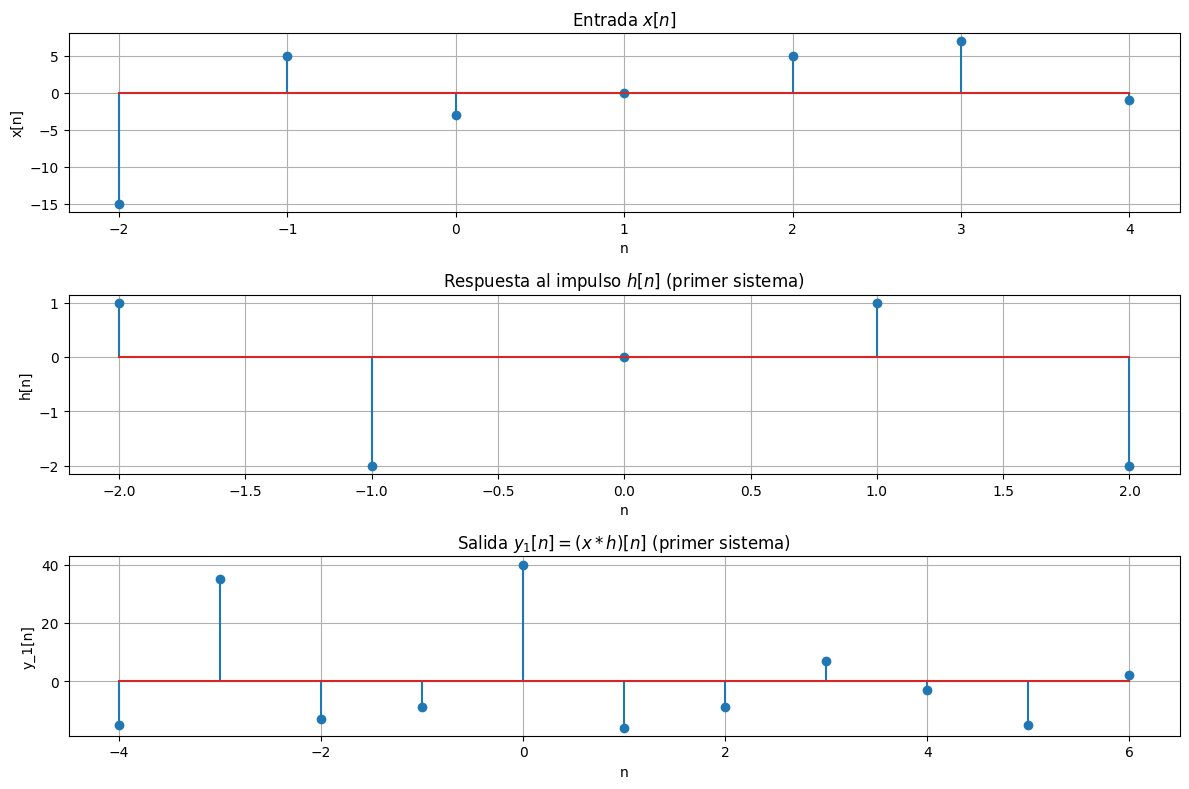

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de x[n] y h[n]
# x[n] = {-15, 5, -3†, 0, 5, 7, -1} con † en n=0 -> índices -2..4
x_vals = np.array([-15, 5, -3, 0, 5, 7, -1], dtype=float)
n_x = np.arange(-2, 5)  # -2, -1, 0, 1, 2, 3, 4

# h[n] = {1, -2, 0†, 1, -2} con † en n=0 -> índices -2..2
h_vals = np.array([1, -2, 0, 1, -2], dtype=float)
n_h = np.arange(-2, 3)  # -2, -1, 0, 1, 2


# Convolución y[n] = x*h
y1 = np.convolve(x_vals, h_vals)

# Soporte teórico: n_min = -2 + (-2) = -4, n_max = 4 + 2 = 6
n_y1 = np.arange(n_x[0] + n_h[0], n_x[-1] + n_h[-1] + 1)

print("y1[n] (primer sistema):")
for ni, yi in zip(n_y1, y1):
    print(f"n = {ni:2d}, y1[n] = {yi:6.1f}")

# Gráficas x[n], h[n], y1[n]
plt.figure(figsize=(12, 8))

# x[n]
plt.subplot(3, 1, 1)
plt.stem(n_x, x_vals)
plt.title("Entrada $x[n]$")
plt.xlabel("n")
plt.ylabel("x[n]")
plt.grid(True)

# h[n]
plt.subplot(3, 1, 2)
plt.stem(n_h, h_vals)
plt.title("Respuesta al impulso $h[n]$ (primer sistema)")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid(True)

# y1[n]
plt.subplot(3, 1, 3)
plt.stem(n_y1, y1)
plt.title("Salida $y_1[n] = (x*h)[n]$ (primer sistema)")
plt.xlabel("n")
plt.ylabel("y_1[n]")
plt.grid(True)

plt.tight_layout()
plt.show()


Respuesta al escalón $s[n]$, impulso $h_2[n]$ y salida $y_2[n]$

h2[n] (respuesta al impulso del 2º sistema):
n = -3, h2[n] =   -1.0
n = -2, h2[n] =    7.0
n = -1, h2[n] =  -16.0
n =  0, h2[n] =   13.0
n =  1, h2[n] =   -2.0
n =  2, h2[n] =  -11.0
n =  3, h2[n] =   12.0
n =  4, h2[n] =    3.0
n =  5, h2[n] =   -5.0

y2[n] (segundo sistema):
n = -5, y2[n] =   15.0
n = -4, y2[n] = -110.0
n = -3, y2[n] =  278.0
n = -2, y2[n] = -296.0
n = -1, y2[n] =  138.0
n =  0, y2[n] =  144.0
n =  1, y2[n] = -259.0
n =  2, y2[n] =   -6.0
n =  3, y2[n] =  151.0
n =  4, y2[n] = -116.0
n =  5, y2[n] =    0.0
n =  6, y2[n] =  110.0
n =  7, y2[n] =  -16.0
n =  8, y2[n] =  -38.0
n =  9, y2[n] =    5.0


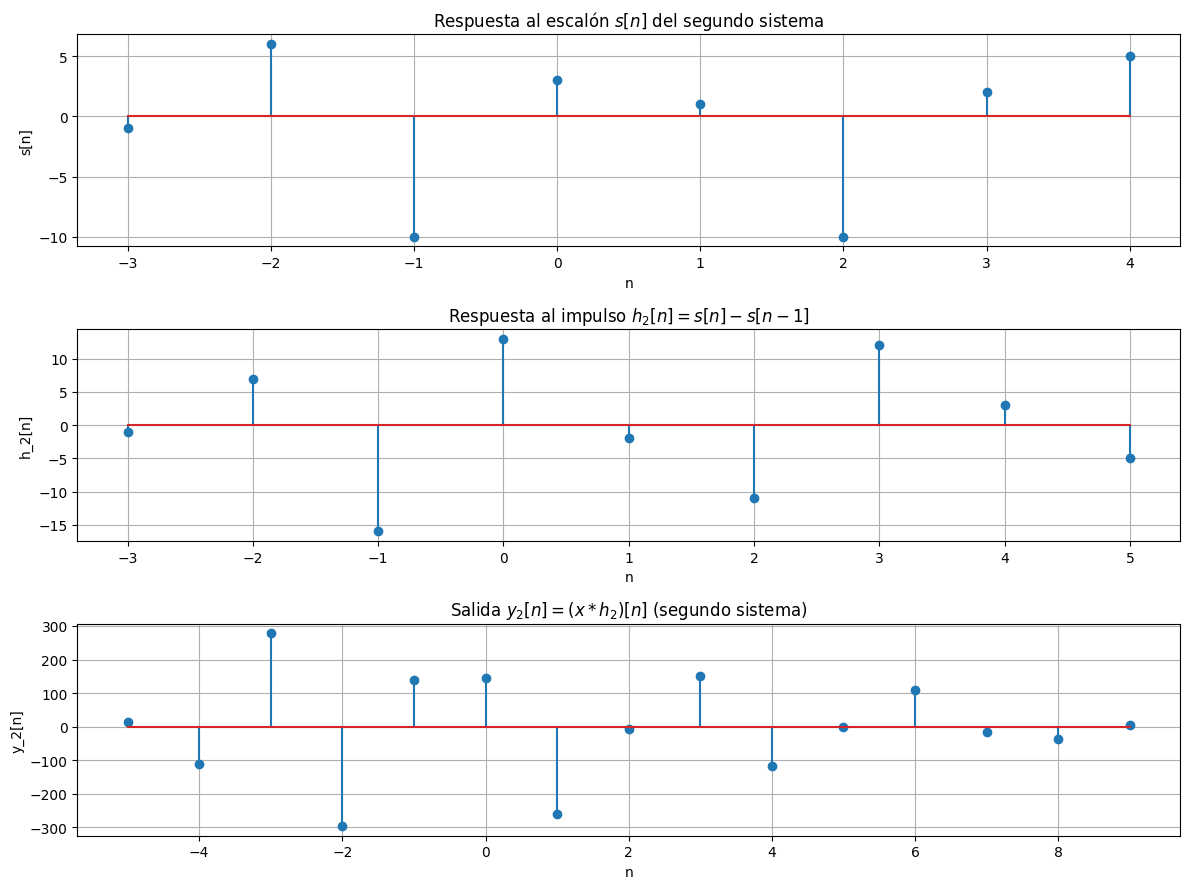

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x[n] otra vez (misma entrada)
x_vals = np.array([-15, 5, -3, 0, 5, 7, -1], dtype=float)
n_x = np.arange(-2, 5)

# Respuesta al escalón s[n]
# s[n] = {-1, 6, -10, 3†, 1, -10, 2, 5} con † en n=0 -> índices -3..4
s_vals = np.array([-1, 6, -10, 3, 1, -10, 2, 5], dtype=float)
n_s = np.arange(-3, 5)  # -3, -2, -1, 0, 1, 2, 3, 4

# Extendemos s[n] con ceros fuera de ese rango para definir h2[n] = s[n] - s[n-1]
def s_ext(n):
    if n < n_s[0] or n > n_s[-1]:
        return 0.0
    return s_vals[n - n_s[0]]

# Elegimos un rango razonable para h2[n], por ejemplo n=-3..5
n_h2 = np.arange(-3, 6)
h2_vals = np.array([s_ext(n) - s_ext(n - 1) for n in n_h2])

print("h2[n] (respuesta al impulso del 2º sistema):")
for ni, hi in zip(n_h2, h2_vals):
    print(f"n = {ni:2d}, h2[n] = {hi:6.1f}")

# Convolución y2[n] = x*h2
y2 = np.convolve(x_vals, h2_vals)
n_y2 = np.arange(n_x[0] + n_h2[0], n_x[-1] + n_h2[-1] + 1)

print("\ny2[n] (segundo sistema):")
for ni, yi in zip(n_y2, y2):
    print(f"n = {ni:2d}, y2[n] = {yi:6.1f}")

# Gráficas: s[n], h2[n], y2[n]
plt.figure(figsize=(12, 9))

# s[n]
plt.subplot(3, 1, 1)
plt.stem(n_s, s_vals)
plt.title("Respuesta al escalón $s[n]$ del segundo sistema")
plt.xlabel("n")
plt.ylabel("s[n]")
plt.grid(True)

# h2[n]
plt.subplot(3, 1, 2)
plt.stem(n_h2, h2_vals)
plt.title("Respuesta al impulso $h_2[n] = s[n] - s[n-1]$")
plt.xlabel("n")
plt.ylabel("h_2[n]")
plt.grid(True)

# y2[n]
plt.subplot(3, 1, 3)
plt.stem(n_y2, y2)
plt.title("Salida $y_2[n] = (x*h_2)[n]$ (segundo sistema)")
plt.xlabel("n")
plt.ylabel("y_2[n]")
plt.grid(True)

plt.tight_layout()
plt.show()


---
###**2.5**
 Sea la señal Gaussiana  
$$x(t) = e^{-a t^{2}}, \quad a \in \mathbb{R}^{+},$$

el sistema A con relación entrada–salida  
$$y_A(t) = x^{2}(t),$$

y el sistema lineal e invariante en el tiempo B con respuesta al impulso  
$$h_B(t) = B e^{-b t^{2}}.$$

a) Encuentre la salida del sistema en serie  
$$x(t) \;\rightarrow\; h_B(t) \;\rightarrow\; y_A(t) \;\rightarrow\; y(t)$$

b) Encuentre la salida del sistema en serie  
$$x(t) \;\rightarrow\; y_A(t) \;\rightarrow\; h_B(t) \;\rightarrow\; y(t).$$

#### Convolución de dos Gaussianas

Primero, necesitamos una fórmula general para la convolución de dos Gaussianas.

Sea

$$
f(t) = e^{-p t^2}, \quad g(t) = e^{-q t^2}, \quad p,q > 0.
$$

La convolución es

$$
(f * g)(t)
= \int_{-\infty}^{\infty} f(\tau)\,g(t-\tau)\,d\tau
= \int_{-\infty}^{\infty} e^{-p\tau^2}\,e^{-q(t-\tau)^2}\,d\tau.
$$

Sumamos exponentes:

$$
\begin{aligned}
-p\tau^2 - q(t-\tau)^2
&= -p\tau^2 - q(t^2 - 2t\tau + \tau^2) \\
&= -p\tau^2 - qt^2 + 2qt\tau - q\tau^2 \\
&= -(p+q)\tau^2 + 2qt\tau - qt^2.
\end{aligned}
$$

Completamos cuadrado para la variable $\tau$:

$$
-(p+q)\tau^2 + 2qt\tau
= -(p+q)\left[\tau^2 - \frac{2qt}{p+q}\tau\right].
$$

Dentro del corchete:

$$
\tau^2 - \frac{2qt}{p+q}\tau
= \left(\tau - \frac{qt}{p+q}\right)^2 - \left(\frac{qt}{p+q}\right)^2.
$$

Entonces

$$
\begin{aligned}
-(p+q)\left[\tau^2 - \frac{2qt}{p+q}\tau\right]
&= -(p+q)\left(\tau - \frac{qt}{p+q}\right)^2
+ (p+q)\left(\frac{qt}{p+q}\right)^2 \\
&= -(p+q)\left(\tau - \frac{qt}{p+q}\right)^2
+ \frac{q^2 t^2}{p+q}.
\end{aligned}
$$

Incluyendo el término $-qt^2$ que faltaba:

$$
\begin{aligned}
-p\tau^2 - q(t-\tau)^2
&= -(p+q)\left(\tau - \frac{qt}{p+q}\right)^2 + \frac{q^2 t^2}{p+q} - qt^2 \\
&= -(p+q)\left(\tau - \frac{qt}{p+q}\right)^2 - \left(q - \frac{q^2}{p+q}\right) t^2 \\
&= -(p+q)\left(\tau - \frac{qt}{p+q}\right)^2 - \frac{pq}{p+q} t^2.
\end{aligned}
$$

Así, la integral queda

$$
\begin{aligned}
(f * g)(t)
&= \int_{-\infty}^{\infty}
\exp\left(
-(p+q)\left(\tau - \frac{qt}{p+q}\right)^2
- \frac{pq}{p+q} t^2
\right)\,d\tau \\
&= e^{-\frac{pq}{p+q}t^2}
\int_{-\infty}^{\infty}
\exp\left(
-(p+q)\left(\tau - \frac{qt}{p+q}\right)^2
\right)\,d\tau.
\end{aligned}
$$

Por el resultado estándar de la integral Gaussiana

$$
\int_{-\infty}^{\infty} e^{-c(\tau-\mu)^2}\,d\tau
= \sqrt{\frac{\pi}{c}}, \quad c>0,
$$

obtenemos

$$
\int_{-\infty}^{\infty}
\exp\left(
-(p+q)\left(\tau - \frac{qt}{p+q}\right)^2
\right)\,d\tau
= \sqrt{\frac{\pi}{p+q}}.
$$

Finalmente,

$$
\boxed{
(f * g)(t) = \sqrt{\frac{\pi}{p+q}}\,
\exp\left(-\frac{pq}{p+q} t^2\right)
}
$$

para $f(t)=e^{-p t^2}$ y $g(t)=e^{-q t^2}$.

###Inciso (a): $x(t) \rightarrow h_B(t) \rightarrow y_A(t) \rightarrow y(t)$

####Primera etapa: paso por el sistema $B$ (convolución con $h_B$)

Se tiene

$$
x(t) = e^{-a t^2}, \qquad
h_B(t) = B e^{-b t^2}.
$$

La salida del sistema $B$ es

$$
z(t) = (x * h_B)(t)
= \int_{-\infty}^{\infty} x(\tau)\,h_B(t-\tau)\,d\tau
= \int_{-\infty}^{\infty} e^{-a\tau^2}\,B e^{-b(t-\tau)^2}\,d\tau.
$$

Sacamos la constante $B$:

$$
z(t) = B \int_{-\infty}^{\infty}
e^{-a\tau^2}\, e^{-b(t-\tau)^2}\,d\tau.
$$

Usamos la fórmula de la sección 1 con

$$
p = a, \qquad q = b.
$$

Entonces

$$
\int_{-\infty}^{\infty}
e^{-a\tau^2}\, e^{-b(t-\tau)^2}\,d\tau
= \sqrt{\frac{\pi}{a+b}}\,\exp\left(-\frac{ab}{a+b}t^2\right).
$$

Por tanto,

$$
z(t) = B \sqrt{\frac{\pi}{a+b}}\,
\exp\left(-\frac{ab}{a+b}t^2\right).
$$

Definimos

$$
\alpha = \frac{ab}{a+b}, \qquad
C_1 = B\sqrt{\frac{\pi}{a+b}},
$$

y entonces

$$
z(t) = C_1 e^{-\alpha t^2}.
$$

##### Segunda etapa: paso por el sistema $A$ (cuadrado)

El sistema $A$ cumple

$$
y_A(t) = x^2(t).
$$

Al aplicarlo a $z(t)$, la salida final del inciso (a) es

$$
y_a(t) = z^2(t).
$$

Por lo tanto,

$$
\begin{aligned}
y_a(t)
&= \left(C_1 e^{-\alpha t^2}\right)^2 \\
&= C_1^2 e^{-2\alpha t^2} \\
&= \left(B\sqrt{\frac{\pi}{a+b}}\right)^2
\exp\left(-2\frac{ab}{a+b}t^2\right) \\
&= \frac{B^2 \pi}{a+b}\,
\exp\left(-\frac{2ab}{a+b}t^2\right).
\end{aligned}
$$

**Resultado del inciso (a):**

$$
\boxed{
y_a(t) = \frac{B^2 \pi}{a+b}\,
\exp\left(-\frac{2ab}{a+b}t^2\right)
}
$$


####Inciso (b): $x(t) \rightarrow y_A(t) \rightarrow h_B(t) \rightarrow y(t)$

#####Primera etapa: paso por el sistema $A$ (cuadrado)

Primero, aplicamos el sistema $A$ a la entrada $x(t)$:

$$
x(t) = e^{-a t^2}
\quad\Rightarrow\quad
w(t) = y_A(t) = x^2(t) = \left(e^{-a t^2}\right)^2 = e^{-2a t^2}.
$$

Es decir, $w(t)$ es una Gaussiana con parámetro $2a$:

$$
w(t) = e^{-2a t^2}.
$$

#####Segunda etapa: paso por el sistema $B$ (convolución con $h_B$)

La salida final del sistema $B$ es

$$
y_b(t) = (w * h_B)(t)
= \int_{-\infty}^{\infty} e^{-2a\tau^2}\, B e^{-b(t-\tau)^2}\,d\tau.
$$

Sacamos $B$:

$$
y_b(t) = B \int_{-\infty}^{\infty} e^{-2a\tau^2}\, e^{-b(t-\tau)^2}\,d\tau.
$$

Usamos la fórmula de convolución de Gaussianas con

$$
p = 2a, \qquad q = b.
$$

Entonces

$$
\int_{-\infty}^{\infty} e^{-2a\tau^2}\, e^{-b(t-\tau)^2}\,d\tau
= \sqrt{\frac{\pi}{2a + b}}\,
\exp\left(-\frac{(2a)b}{2a+b}t^2\right).
$$

Es decir,

$$
y_b(t)
= B \sqrt{\frac{\pi}{2a + b}}\,
\exp\left(-\frac{2ab}{2a+b}t^2\right).
$$

**Resultado del inciso (b):**

$$
\boxed{
y_b(t) = B \sqrt{\frac{\pi}{2a + b}}\,
\exp\left(-\frac{2ab}{2a + b}t^2\right)
}
$$


####Comparación de los dos casos

- En el **inciso (a)**, la salida es

  $$
  y_a(t) = \frac{B^2 \pi}{a+b}\,
  \exp\left(-\frac{2ab}{a+b}t^2\right).
  $$

- En el **inciso (b)**, la salida es

  $$
  y_b(t) = B \sqrt{\frac{\pi}{2a + b}}\,
  \exp\left(-\frac{2ab}{2a + b}t^2\right).
  $$

Se observa que:

- Los **coeficientes de los exponentes** son distintos:

  $$
  \frac{2ab}{a+b} \neq \frac{2ab}{2a+b} \quad \text{(en general)}.
  $$

- Las **amplitudes** (factores frontales) también son diferentes.

Esto muestra que el resultado depende del orden de los sistemas $A$ y $B$, es decir:

$$
A \circ B \neq B \circ A,
$$

porque $A$ es un sistema **no lineal** (cuadrado) y sólo los sistemas lineales conmutan entre sí en cascada.

####Gráficas

Error máximo caso (a) en la región central: 8.804e-09
Error máximo caso (b) en la región central: 6.842e-09


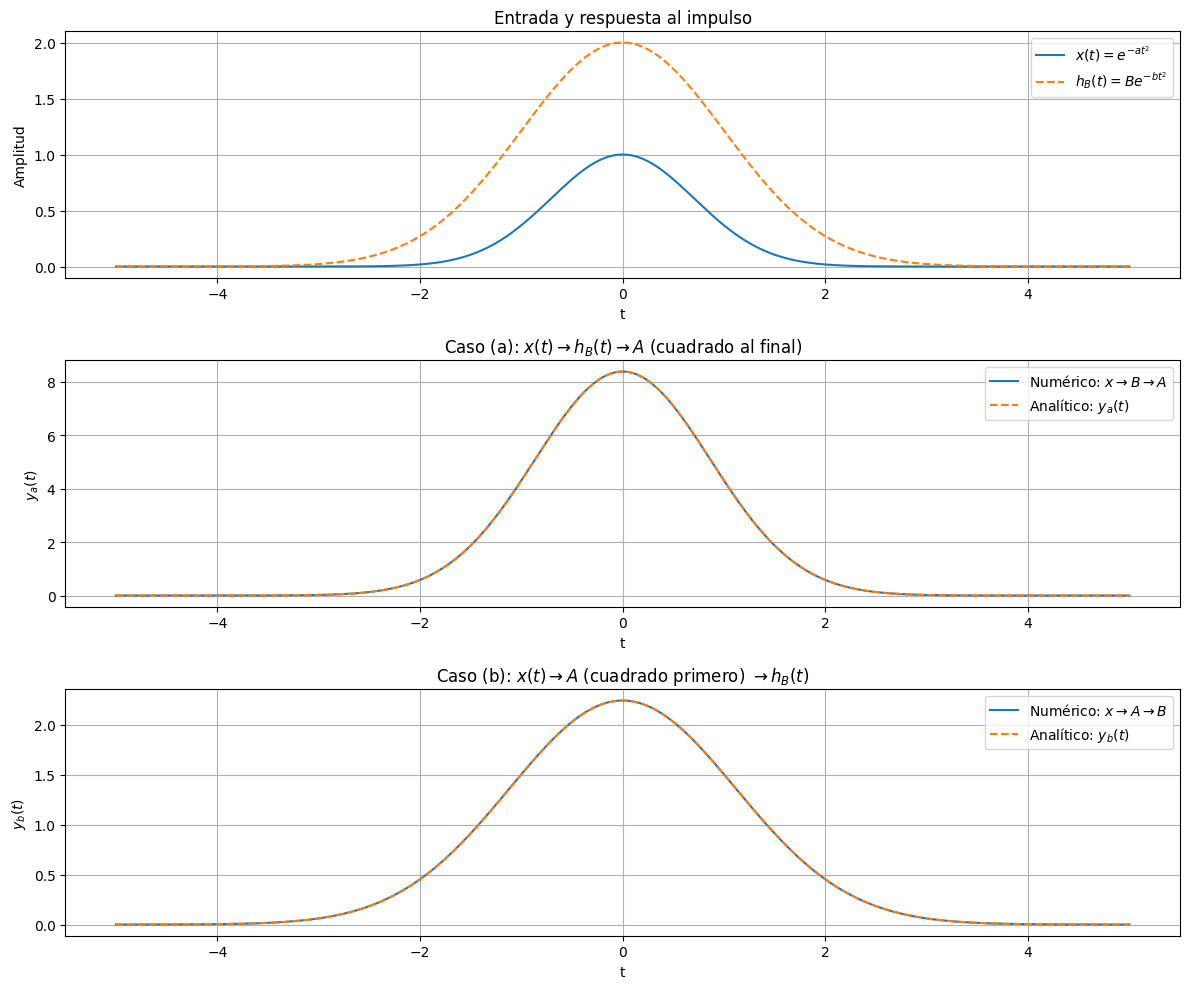

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
a = 1.0     # parámetro de x(t)
b = 0.5     # parámetro de h_B(t)
B = 2.0     # ganancia del sistema B

# Malla de tiempo (continua aproximada)
t_max = 5.0
dt = 0.01
t = np.arange(-t_max, t_max + dt, dt)
N = len(t)

# Señales básicas
# x(t) = e^{-a t^2}
x = np.exp(-a * t**2)

# h_B(t) = B e^{-b t^2}
hB = B * np.exp(-b * t**2)

# CASO (a):
# x(t) -> B (convolución con hB) -> A (cuadrado)
# 1) z1(t) = (x * hB)(t) aproximado con convolución discreta
z1 = np.convolve(x, hB, mode='same') * dt   # aproximación a convolución continua

# 2) Paso por A: y_a_num(t) = z1(t)^2
y_a_num = z1**2

# Expresión analítica que dedujimos:
# y_a(t) = (B^2 * pi / (a + b)) * exp(-(2ab/(a+b)) * t^2)
y_a_anal = (B**2 * np.pi / (a + b)) * np.exp(-(2 * a * b / (a + b)) * t**2)

# CASO (b):
# x(t) -> A (cuadrado) -> B (convolución con hB)
# 1) w(t) = x^2(t)
w = x**2

# 2) y_b_num(t) = (w * hB)(t)
y_b_num = np.convolve(w, hB, mode='same') * dt

# Expresión analítica:
# y_b(t) = B * sqrt(pi / (2a + b)) * exp(-(2ab/(2a + b)) * t^2)
y_b_anal = B * np.sqrt(np.pi / (2 * a + b)) * np.exp(-(2 * a * b / (2 * a + b)) * t**2)

# Errores numérico vs analítico (ignorando bordes)
mask_centro = np.abs(t) < t_max * 0.7  # evitamos bordes donde se recorta la convolución

err_a = np.max(np.abs(y_a_num[mask_centro] - y_a_anal[mask_centro]))
err_b = np.max(np.abs(y_b_num[mask_centro] - y_b_anal[mask_centro]))

print(f"Error máximo caso (a) en la región central: {err_a:.3e}")
print(f"Error máximo caso (b) en la región central: {err_b:.3e}")

# Gráficas
plt.figure(figsize=(12, 10))

# x(t) y hB(t)
plt.subplot(3, 1, 1)
plt.plot(t, x, label='$x(t) = e^{-a t^2}$')
plt.plot(t, hB, linestyle='--', label='$h_B(t) = B e^{-b t^2}$')
plt.title("Entrada y respuesta al impulso")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()

# Caso (a): x -> B -> A
plt.subplot(3, 1, 2)
plt.plot(t, y_a_num, label='Numérico: $x \\to B \\to A$')
plt.plot(t, y_a_anal, linestyle='--', label='Analítico: $y_a(t)$')
plt.title("Caso (a): $x(t) \\to h_B(t) \\to A$ (cuadrado al final)")
plt.xlabel("t")
plt.ylabel("$y_a(t)$")
plt.grid(True)
plt.legend()

# Caso (b): x -> A -> B
plt.subplot(3, 1, 3)
plt.plot(t, y_b_num, label='Numérico: $x \\to A \\to B$')
plt.plot(t, y_b_anal, linestyle='--', label='Analítico: $y_b(t)$')
plt.title("Caso (b): $x(t) \\to A$ (cuadrado primero) $\\to h_B(t)$")
plt.xlabel("t")
plt.ylabel("$y_b(t)$")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


---
###**2.6 Definición transformada de la Laplace**

### Transformada de Laplace y ROC a partir del gráfico de polos y ceros

Partimos de la idea general:

- La transformada de Laplace de una señal $x(t)$ es
  $$
  X(s) = \mathcal{L}\{x(t)\} = \int_{-\infty}^{\infty} x(t)\,e^{-st}\,dt,
  \quad s = \sigma + j\omega \in \mathbb{C}.
  $$
- El gráfico de **polos y ceros** en el plano $s$ nos dice dónde están las raíces del numerador (ceros) y del denominador (polos) de $X(s)$.

Una forma racional típica es

$$
X(s) = \frac{\sum_{m=0}^{M} \beta_m s^m}{\sum_{n=0}^{N} \alpha_n s^n}
= K \cdot \frac{\prod_{\mu=0}^{Q} (s - s_{0,\mu})}{\prod_{\nu=0}^{P} (s - s_{\infty,\nu})},
$$

donde:
- $s_{0,\mu}$ son los **ceros**,
- $s_{\infty,\nu}$ son los **polos**,
- $K$ es un factor constante.


#### Ejemplo: señal exponencial compleja causal

Se considera la señal exponencial compleja **causal**

$$
x(t) = e^{-s_0 t} u(t),
$$

donde:
- $s_0 \in \mathbb{C}$ es la **frecuencia compleja**,
- $u(t)$ es el escalón unitario.

La transformada de Laplace se define como

$$
X(s) = \int_{-\infty}^{\infty} x(t) e^{-st}\,dt.
$$

Como $x(t)$ es causal (es cero para $t<0$), la integral se reduce a

$$
X(s) = \int_{0}^{\infty} e^{-s_0 t} e^{-st}\,dt
= \int_{0}^{\infty} e^{-(s + s_0)t}\,dt.
$$

####Cálculo de $X(s)$

Tenemos la integral

$$
X(s) = \int_{0}^{\infty} e^{-(s + s_0)t}\,dt.
$$

Esta es una integral exponencial estándar. Sabemos que

$$
\int_{0}^{\infty} e^{-\lambda t}\,dt =
\begin{cases}
\frac{1}{\lambda}, & \text{si } \Re\{\lambda\} > 0,\\[4pt]
\text{diverge}, & \text{si } \Re\{\lambda\} \le 0.
\end{cases}
$$

En nuestro caso, $\lambda = s + s_0$, por lo tanto, si $\Re\{s + s_0\} > 0$:

$$
\begin{aligned}
X(s)
&= \int_{0}^{\infty} e^{-(s + s_0)t}\,dt \\
&= \left[ \frac{e^{-(s+s_0)t}}{-(s+s_0)} \right]_{0}^{\infty} \\
&= 0 - \left( \frac{1}{-(s+s_0)} \right) \\
&= \frac{1}{s + s_0}.
\end{aligned}
$$

Por tanto,

$$
\boxed{
X(s) = \frac{1}{s + s_0}
}
$$

siempre que la integral converja.

####Región de convergencia (ROC)

La condición de convergencia es

$$
\Re\{s + s_0\} > 0.
$$

Es decir:

$$
\Re\{s\} + \Re\{s_0\} > 0
\quad \Rightarrow \quad
\Re\{s\} > -\Re\{s_0\}.
$$

La **ROC** (región de convergencia) para esta señal causal es entonces:

$$
\boxed{
\text{ROC: } \Re\{s\} > -\Re\{s_0\}
}
$$

####Relación con el gráfico de polos y ceros

A partir de

$$
X(s) = \frac{1}{s + s_0},
$$

podemos identificar:

- El denominador es $s + s_0 = 0 \;\Rightarrow\; s = -s_0$.
- No hay ceros finitos (el numerador es constante).

Entonces:

- Hay un **polo** simple en
  $$
  s = -s_0.
  $$
- No hay **ceros** finitos en el plano $s$ (podrías pensar en un cero “en el infinito”).
- El factor de ganancia es
  $$
  K = 1.
  $$

En el **plano de polos y ceros**:

- Se dibuja una “X” o “×” en la posición del polo: $s = -s_0$.
- No se dibujan ceros (no hay "o" o "◦" en el plano finito).

La **ROC** para una señal causal está a la derecha del polo más a la derecha.  
Como aquí sólo hay un polo en $s = -s_0$, la ROC es

$$
\Re\{s\} > -\Re\{s_0\},
$$

lo que coincide exactamente con la condición de convergencia que obtuvimos a partir de la integral.

####Ejemplo numérico: $s_0 = 1 + j$

Si tomamos el caso particular

$$
s_0 = 1 + j,
$$

entonces

$$
X(s) = \frac{1}{s + (1 + j)} = \frac{1}{s + 1 + j}.
$$

El polo está en

$$
s = -s_0 = -(1 + j) = -1 - j.
$$

Y la ROC viene dada por

$$
\Re\{s\} > -\Re\{s_0\} = -1.
$$

Es decir, la ROC es el **semiplano derecho** definido por

$$
\boxed{
\Re\{s\} > -1
}
$$

En el gráfico de polos y ceros:

- Dibujas un polo en el punto $s = -1 - j$.
- La región de convergencia es todo el semiplano a la derecha de la recta vertical $\sigma = -1$ (sin incluir la línea del polo).

Esto se corresponde con la transformada de Laplace de la señal exponencial compleja causal

$$
x(t) = e^{-(1+j)t}u(t),
$$

cuyo espectro $X(s)$ tiene exactamente ese **polo** y esa **ROC**.


####Parámetros y definición de 𝑋(𝑠)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro del ejemplo
s0 = 1 + 1j   # s0 = 1 + j
pole = -s0    # polo en s = -s0 = -1 - j

def X(s):
    """Transformada de Laplace X(s) = 1 / (s + s0)."""
    return 1.0 / (s + s0)


####Diagrama de polos y ROC

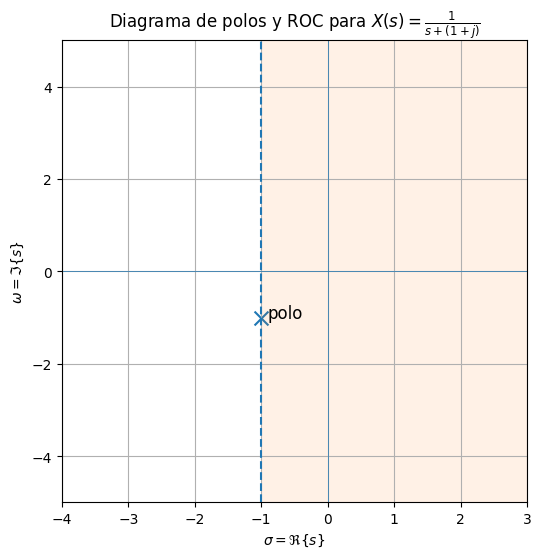

In [ ]:
plt.figure(figsize=(6, 6))

# Polo
plt.scatter(pole.real, pole.imag, marker='x', s=100)
plt.text(pole.real + 0.1, pole.imag, 'polo', fontsize=12)

# Línea vertical que pasa por el polo (frontera de la ROC)
plt.axvline(x=pole.real, linestyle='--')

# Sombrear la ROC: semiplano derecho Re{s} > -1
w_min, w_max = -5, 5
sigma_min, sigma_max = -4, 3

omega_grid = np.linspace(w_min, w_max, 2)
plt.fill_betweenx(omega_grid, pole.real, sigma_max, alpha=0.1)

plt.xlim(sigma_min, sigma_max)
plt.ylim(w_min, w_max)
plt.xlabel(r'$\sigma = \Re\{s\}$')
plt.ylabel(r'$\omega = \Im\{s\}$')
plt.title(r'Diagrama de polos y ROC para $X(s)=\frac{1}{s + (1+j)}$')

plt.grid(True)
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)

plt.show()


####Magnitud y fase sobre el eje imaginario 𝑠=𝑗𝜔

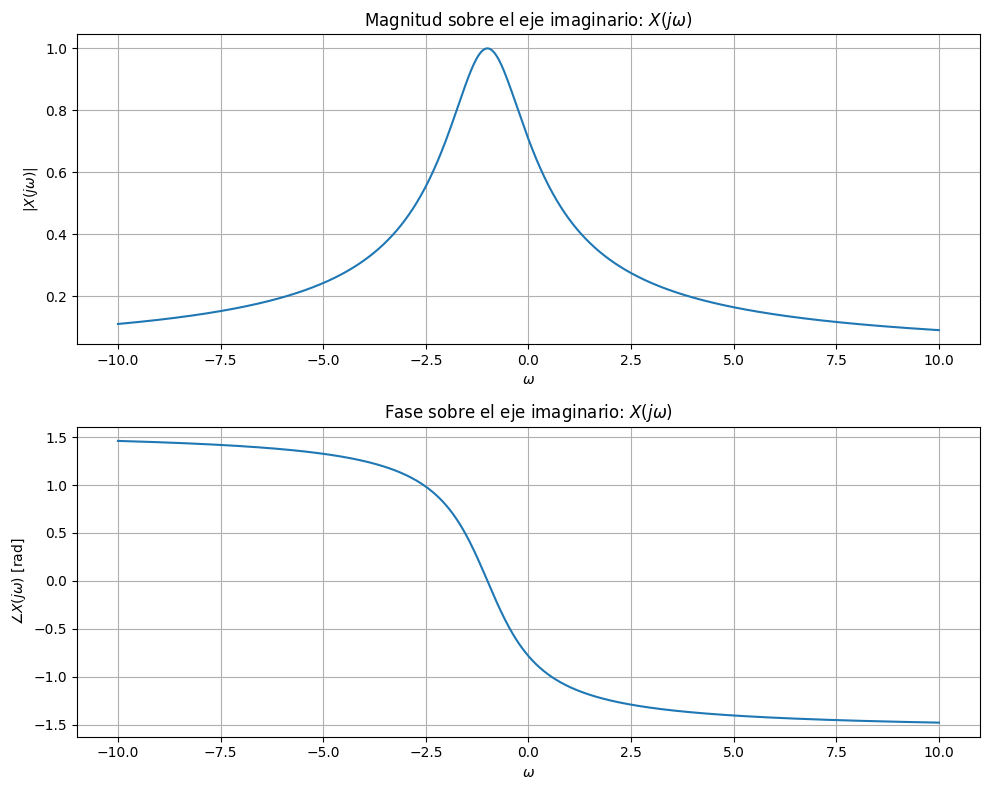

In [ ]:
omega = np.linspace(-10, 10, 1000)
s_jw = 1j * omega
X_jw = X(s_jw)

mag_jw = np.abs(X_jw)
phase_jw = np.angle(X_jw)

plt.figure(figsize=(10, 8))

# Magnitud
plt.subplot(2, 1, 1)
plt.plot(omega, mag_jw)
plt.title(r'Magnitud sobre el eje imaginario: $X(j\omega)$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$|X(j\omega)|$')
plt.grid(True)

# Fase
plt.subplot(2, 1, 2)
plt.plot(omega, phase_jw)
plt.title(r'Fase sobre el eje imaginario: $X(j\omega)$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\angle X(j\omega)$ [rad]')
plt.grid(True)

plt.tight_layout()
plt.show()


---
###**2.7 Consultar y realizar los ejercicios del cuaderno Propiedades báasicas transformada de la Laplace**



## Transformada de Laplace de $\epsilon(t)\,\sin(\omega_0 t)$ – procedimiento paso a paso

Vamos a tomar:

$$
x(t) = \epsilon(t)\,\sin(\omega_0 t),
$$

donde $\epsilon(t)$ es el escalón unitario ($\epsilon(t)=u(t)$) y $\omega_0 \in \mathbb{R}^+$.

Queremos:

1. Calcular paso a paso $X(s) = \mathcal{L}\{x(t)\}$.
2. Encontrar polos y ceros.
3. Ver qué simetría muestran en el plano $s$.


#####Definición de la transformada de Laplace

La transformada de Laplace bilateral de $x(t)$ es

$$
X(s) = \mathcal{L}\{x(t)\}
= \int_{-\infty}^{\infty} x(t)\,e^{-s t}\,dt,
\qquad s = \sigma + j\omega \in \mathbb{C}.
$$

Como $x(t) = \epsilon(t)\,\sin(\omega_0 t)$ es causal (vale 0 para $t<0$), la integral se reduce a

$$
X(s) = \int_{0}^{\infty} \sin(\omega_0 t)\,e^{-s t}\,dt.
$$


#####Escribir el seno en forma exponencial

Usamos la identidad de Euler para el seno:

$$
\sin(\omega_0 t)
= \frac{e^{j\omega_0 t} - e^{-j\omega_0 t}}{2j}.
$$

Sustituimos en la integral:

$$
\begin{aligned}
X(s)
&= \int_{0}^{\infty} \sin(\omega_0 t)\,e^{-s t}\,dt \\[4pt]
&= \int_{0}^{\infty} \frac{e^{j\omega_0 t} - e^{-j\omega_0 t}}{2j}\,e^{-s t}\,dt \\[4pt]
&= \frac{1}{2j} \int_{0}^{\infty}
\big( e^{j\omega_0 t} - e^{-j\omega_0 t} \big)\,e^{-s t}\,dt.
\end{aligned}
$$

Multiplicamos los exponentes:

- Para el primer término:
  $$
  e^{j\omega_0 t}\,e^{-s t} = e^{-(s - j\omega_0)t}.
  $$
- Para el segundo término:
  $$
  e^{-j\omega_0 t}\,e^{-s t} = e^{-(s + j\omega_0)t}.
  $$

Entonces:

$$
\begin{aligned}
X(s)
&= \frac{1}{2j} \int_{0}^{\infty}
\big( e^{-(s - j\omega_0)t} - e^{-(s + j\omega_0)t} \big)\,dt \\[4pt]
&= \frac{1}{2j} \left[
\int_{0}^{\infty} e^{-(s - j\omega_0)t}\,dt
\;-\;
\int_{0}^{\infty} e^{-(s + j\omega_0)t}\,dt
\right].
\end{aligned}
$$

####Cálculo de las integrales exponenciales

Recordemos la integral estándar:

$$
\int_{0}^{\infty} e^{-\lambda t}\,dt =
\begin{cases}
\frac{1}{\lambda}, & \Re\{\lambda\} > 0, \\[4pt]
\text{diverge}, & \Re\{\lambda\} \le 0.
\end{cases}
$$

Aquí tenemos dos parámetros:

- Para el primer término: $\lambda_1 = s - j\omega_0$.
- Para el segundo término: $\lambda_2 = s + j\omega_0$.

Notar que:

$$
\Re\{\lambda_1\} = \Re\{s - j\omega_0\} = \Re\{s\},
$$
$$
\Re\{\lambda_2\} = \Re\{s + j\omega_0\} = \Re\{s\}.
$$

Por lo tanto, **las dos integrales convergen si y sólo si**

$$
\Re\{s\} > 0.
$$

Asumiendo $\Re\{s\} > 0$:

$$
\int_{0}^{\infty} e^{-(s - j\omega_0)t}\,dt = \frac{1}{s - j\omega_0},
$$

$$
\int_{0}^{\infty} e^{-(s + j\omega_0)t}\,dt = \frac{1}{s + j\omega_0}.
$$

Sustituimos de nuevo:

$$
\begin{aligned}
X(s)
&= \frac{1}{2j} \left[
\frac{1}{s - j\omega_0} - \frac{1}{s + j\omega_0}
\right], \qquad \Re\{s\} > 0.
\end{aligned}
$$


#### Simplificar la expresión de $X(s)$

Tenemos:

$$
X(s) = \frac{1}{2j} \left[
\frac{1}{s - j\omega_0} - \frac{1}{s + j\omega_0}
\right].
$$

Llevamos los dos términos a un denominador común:

1. Denominador común:

$$
(s - j\omega_0)(s + j\omega_0) = s^2 + \omega_0^2.
$$

2. Diferencia de fracciones:

$$
\begin{aligned}
\frac{1}{s - j\omega_0} - \frac{1}{s + j\omega_0}
&= \frac{s + j\omega_0}{(s - j\omega_0)(s + j\omega_0)}
    - \frac{s - j\omega_0}{(s - j\omega_0)(s + j\omega_0)} \\[4pt]
&= \frac{s + j\omega_0 - (s - j\omega_0)}{s^2 + \omega_0^2} \\[4pt]
&= \frac{s + j\omega_0 - s + j\omega_0}{s^2 + \omega_0^2} \\[4pt]
&= \frac{2j\omega_0}{s^2 + \omega_0^2}.
\end{aligned}
$$

Entonces:

$$
\begin{aligned}
X(s)
&= \frac{1}{2j} \cdot \frac{2j\omega_0}{s^2 + \omega_0^2} \\[4pt]
&= \frac{\omega_0}{s^2 + \omega_0^2}.
\end{aligned}
$$

La **transformada de Laplace** es

$$
\boxed{
X(s) = \frac{\omega_0}{s^2 + \omega_0^2},
\qquad \text{ROC: } \Re\{s\} > 0.
}
$$

####Determinar polos y ceros

La expresión racional es

$$
X(s) = \frac{\omega_0}{s^2 + \omega_0^2}.
$$

####Ceros

Los ceros son las raíces del **numerador**:

$$
\omega_0 = 0.
$$

Como $\omega_0$ es un parámetro fijo y no es función de $s$, no depende de $s$.  
Si $\omega_0 \neq 0$ (caso interesante), el numerador **no se anula para ningún $s$ finito**.

Por lo tanto:

$$
\boxed{\text{No hay ceros finitos de } X(s).}
$$

(Se podría decir informalmente que hay un “cero en el infinito”, pero en el plano $s$ finito, no hay ceros.)


####Polos

Los polos son las raíces del **denominador**:

$$
s^2 + \omega_0^2 = 0.
$$

Resolvemos para $s$:

$$
s^2 = -\omega_0^2
\quad\Rightarrow\quad
s = \pm j\omega_0.
$$

Por lo tanto, los **polos** son

$$
\boxed{
s_{p,1} = j\omega_0, \qquad s_{p,2} = -j\omega_0.
}
$$

En forma factorizada:

$$
s^2 + \omega_0^2 = (s - j\omega_0)(s + j\omega_0),
$$

así que

$$
X(s) = \frac{\omega_0}{(s - j\omega_0)(s + j\omega_0)}.
$$

#### Simetría de los polos y de $X(s)$

#### Simetría de los polos en el plano $s$

Las raíces del denominador son:

$$
s_{p,1} = j\omega_0, \qquad s_{p,2} = -j\omega_0.
$$

Notamos que:

$$
(j\omega_0)^* = -j\omega_0.
$$

Es decir,

- $s_{p,2} = s_{p,1}^*$.

Esto significa que los polos están ubicados como **par conjugado complejo**:

- Uno en el eje imaginario positivo ($j\omega_0$),
- Otro en el eje imaginario negativo ($-j\omega_0$).

Gráficamente:

- Están simétricos respecto del **eje real** (un polo arriba, otro abajo, misma distancia).
- Al estar en el eje imaginario puro, también son simétricos respecto al origen en ese eje.


####Relación con la teoría de simetría para señales reales

La señal original

$$
x(t) = \epsilon(t)\,\sin(\omega_0 t)
$$

es **real** para todo $t$. Por tanto, se cumple la simetría:

$$
X(s) = X^*(s^*).
$$

Esto implica:

1. Los coeficientes de los polinomios en $s$ (numerador y denominador) de $X(s)$ son **reales**.
2. Por el teorema de las raíces de polinomios con coeficientes reales, las raíces (polos y ceros) son:
   - Reales, o
   - Aparecen en **pares conjugados complejos**.

En nuestro caso:

- El denominador es $s^2 + \omega_0^2$ con coeficientes reales.
- Sus raíces son $\pm j\omega_0$, que forman un par conjugado complejo.
- El numerador es constante real $\omega_0$, por lo que no introduce ceros complejos finitos.

Así, la **transformada de Laplace de esta señal real**:

- Muestra la simetría conjugada compleja en sus polos.
- No tiene ceros finitos, consistentes con un numerador real constante.


####Resumen final

- **Transformada de Laplace**:
  $$
  X(s) = \frac{\omega_0}{s^2 + \omega_0^2},
  \qquad \Re\{s\} > 0.
  $$

- **Polos**:
  $$
  s = j\omega_0 \quad \text{y} \quad s = -j\omega_0,
  $$
  formando un **par conjugado complejo**, simétrico respecto del eje real (y respecto del origen sobre el eje imaginario).

- **Ceros finitos**:
  $$
  \text{Ninguno (numerador constante)}.
  $$

- Esta estructura de polos cumple exactamente la simetría esperada para la transformada de Laplace de una señal real $x(t)$: polos (y ceros, si los hubiera) reales o en pares conjugados complejos.


---
###**2.8 Demostración de propiedades de la transformada de Laplace (desde la definición)**

Tomamos la **transformada de Laplace bilateral** como

$$
\mathcal{L}\{x(t)\} = X(s)
= \int_{-\infty}^{\infty} x(t)\,e^{-s t}\,dt,
\qquad s = \sigma + j\omega \in \mathbb{C}.
$$

Asumimos que las integrales convergen en la región de convergencia (ROC) correspondiente, y que las señales son suficientemente “bien portadas” (absolutamente integrables o con crecimiento exponencial controlado) para justificar cambios de variable, intercambio de integrales, etc.

###(a) Desplazamiento en el tiempo

**Enunciado:**

$$
\mathcal{L}\{x(t - t_0)\} = e^{-s t_0} X(s).
$$

Para simplicidad, tomamos $t_0 \in \mathbb{R}$ fijo.

### Paso 1: aplicar la definición

Por definición,

$$
\mathcal{L}\{x(t - t_0)\}
= \int_{-\infty}^{\infty} x(t - t_0)\,e^{-s t}\,dt.
$$

### Paso 2: cambio de variable

Hacemos el cambio de variable

$$
\tau = t - t_0 \quad \Rightarrow \quad t = \tau + t_0, \quad dt = d\tau.
$$

Cuando $t$ recorre $(-\infty, \infty)$, también lo hace $\tau$, así que los límites quedan igual:

$$
\begin{aligned}
\mathcal{L}\{x(t - t_0)\}
&= \int_{-\infty}^{\infty} x(\tau)\, e^{-s(\tau + t_0)}\,d\tau \\[4pt]
&= \int_{-\infty}^{\infty} x(\tau)\, e^{-s\tau}\,e^{-s t_0}\,d\tau \\[4pt]
&= e^{-s t_0} \int_{-\infty}^{\infty} x(\tau)\, e^{-s\tau}\,d\tau.
\end{aligned}
$$

### Paso 3: identificar $X(s)$

Por definición de la transformada de Laplace,

$$
\int_{-\infty}^{\infty} x(\tau)\, e^{-s\tau}\,d\tau = X(s).
$$

Por lo tanto,

$$
\boxed{
\mathcal{L}\{x(t - t_0)\} = e^{-s t_0} X(s).
}
$$

---

### (b) Escalamiento en el tiempo

**Enunciado:**

$$
\mathcal{L}\{x(a t)\} = \frac{1}{|a|}\, X\!\left(\frac{s}{a}\right),
\qquad a \in \mathbb{R}\setminus\{0\}.
$$

Demostraremos primero el caso $a>0$ y luego $a<0$.

### Caso 1: $a > 0$

Partimos de la definición:

$$
\mathcal{L}\{x(a t)\}
= \int_{-\infty}^{\infty} x(a t)\, e^{-s t}\,dt.
$$

Hacemos el cambio de variable

$$
u = a t \quad \Rightarrow \quad t = \frac{u}{a}, \quad dt = \frac{1}{a} du.
$$

Cuando $t$ recorre $(-\infty,\infty)$, como $a>0$, también lo hace $u$ de $-\infty$ a $\infty$.

Entonces:

$$
\begin{aligned}
\mathcal{L}\{x(a t)\}
&= \int_{-\infty}^{\infty} x(u)\,
e^{-s \frac{u}{a}}\,
\frac{1}{a}\,du \\[4pt]
&= \frac{1}{a}\int_{-\infty}^{\infty} x(u)\,
e^{-(s/a)\,u}\,du.
\end{aligned}
$$

Reconocemos que

$$
\int_{-\infty}^{\infty} x(u)\,e^{-(s/a)\,u}\,du
= X\!\left(\frac{s}{a}\right),
$$

así que

$$
\mathcal{L}\{x(a t)\}
= \frac{1}{a}\,X\!\left(\frac{s}{a}\right),
\qquad a>0.
$$

### Caso 2: $a < 0$

Tomamos $a<0$. De nuevo:

$$
\mathcal{L}\{x(a t)\}
= \int_{-\infty}^{\infty} x(a t)\, e^{-s t}\,dt.
$$

Usamos el mismo cambio $u = a t$, pero ahora, como $a<0$, los límites se invierten:

- Cuando $t \to -\infty$, $u = a t \to +\infty$.
- Cuando $t \to +\infty$, $u = a t \to -\infty$.

Tenemos:

$$
u = a t \quad \Rightarrow \quad t = \frac{u}{a}, \quad dt = \frac{1}{a} du.
$$

Entonces

$$
\begin{aligned}
\mathcal{L}\{x(a t)\}
&= \int_{t=-\infty}^{t=\infty}
x(a t)\, e^{-s t}\,dt \\
&= \int_{u=\infty}^{u=-\infty}
x(u)\, e^{-s \frac{u}{a}}\,\frac{1}{a}\,du.
\end{aligned}
$$

Invertimos los límites para ponerlos en orden creciente, lo que introduce un signo menos:

$$
\int_{\infty}^{-\infty} (\cdot)\,du = -\int_{-\infty}^{\infty} (\cdot)\,du.
$$

Obtenemos:

$$
\begin{aligned}
\mathcal{L}\{x(a t)\}
&= -\frac{1}{a} \int_{-\infty}^{\infty} x(u)\,e^{-(s/a)\,u}\,du.
\end{aligned}
$$

Como $a<0$, $-\frac{1}{a} = \frac{1}{|a|}$, y de nuevo la integral es $X(s/a)$:

$$
\mathcal{L}\{x(a t)\}
= \frac{1}{|a|} \int_{-\infty}^{\infty} x(u)\,e^{-(s/a)\,u}\,du
= \frac{1}{|a|} X\!\left(\frac{s}{a}\right).
$$

Por lo tanto, juntando ambos casos:

$$
\boxed{
\mathcal{L}\{x(a t)\}
= \frac{1}{|a|} X\!\left(\frac{s}{a}\right),
\quad a \ne 0.
}
$$

---

### (c) Transformada de la derivada

**Enunciado (bajo condiciones adecuadas):**

$$
\mathcal{L}\left\{\frac{d}{dt}x(t)\right\} = sX(s)
$$

(asumiendo que los términos de borde se anulan; más general: aparece un término de borde).

### Paso 1: definición

Sea $x(t)$ derivable y suficientemente bien comportada. Consideramos

$$
\mathcal{L}\left\{\frac{d}{dt}x(t)\right\}
= \int_{-\infty}^{\infty} x'(t)\,e^{-s t}\,dt.
$$

### Paso 2: integración por partes

Usamos integración por partes con

- $u = e^{-s t}$,   $dv = x'(t)\,dt$,
- $du = -s e^{-s t}\,dt$,   $v = x(t)$.

La fórmula es

$$
\int u\,dv = uv - \int v\,du.
$$

Aplicamos:

$$
\begin{aligned}
\int_{-\infty}^{\infty} x'(t)e^{-s t}\,dt
&= \left. x(t)\,e^{-s t} \right|_{t=-\infty}^{t=\infty}
 - \int_{-\infty}^{\infty} x(t)\,(-s e^{-s t})\,dt \\[4pt]
&= \left. x(t)\,e^{-s t} \right|_{t=-\infty}^{t=\infty}
 + s \int_{-\infty}^{\infty} x(t)\,e^{-s t}\,dt.
\end{aligned}
$$

El segundo término es claramente $s X(s)$.  
Para el primer término, asumimos que

$$
\lim_{t\to\infty} x(t)e^{-s t} = 0,
\qquad
\lim_{t\to -\infty} x(t)e^{-s t} = 0,
$$

en la ROC (esto es típico para señales con crecimiento no muy rápido y $\Re\{s\}$ suficientemente grande/adecuado).

Entonces

$$
\left. x(t)\,e^{-s t} \right|_{t=-\infty}^{t=\infty} = 0 - 0 = 0.
$$

Por tanto:

$$
\mathcal{L}\{x'(t)\}
= s X(s).
$$

Bajo esas condiciones de borde, se cumple

$$
\boxed{
\mathcal{L}\left\{\frac{d}{dt}x(t)\right\} = s X(s).
}
$$

> Nota: en la transformada de Laplace unilateral (integrando de $0^-$ a $\infty$) aparece un término adicional $-x(0^-)$; aquí hemos asumido condiciones que hacen desaparecer los términos de borde en $\pm\infty$.

---

### (d) Transformada de la convolución

**Enunciado:**

Si

$$
(x * y)(t) = \int_{-\infty}^{\infty} x(\tau)\,y(t-\tau)\,d\tau,
$$

entonces

$$
\mathcal{L}\{x(t) * y(t)\} = X(s)\,Y(s).
$$

### Paso 1: escribir la transformada de la convolución

Por definición de transformada y de convolución:

$$
\mathcal{L}\{(x * y)(t)\}
= \int_{-\infty}^{\infty} (x * y)(t)\,e^{-s t}\,dt
= \int_{-\infty}^{\infty}
\left[ \int_{-\infty}^{\infty} x(\tau)\,y(t-\tau)\,d\tau \right]
e^{-s t}\,dt.
$$

Supondremos que podemos cambiar el orden de integración (condiciones de convergencia adecuadas, Fubini/Tonelli):

$$
\mathcal{L}\{x * y\}
= \int_{-\infty}^{\infty} x(\tau) \left[
\int_{-\infty}^{\infty} y(t-\tau)\,e^{-s t}\,dt
\right] d\tau.
$$

### Paso 2: cambio de variable en la integral interna

Consideramos la integral interna:

$$
\int_{-\infty}^{\infty} y(t-\tau)\,e^{-s t}\,dt.
$$

Hacemos el cambio de variable

$$
u = t - \tau
\quad\Rightarrow\quad
t = u + \tau,
\quad dt = du.
$$

Cuando $t$ va de $-\infty$ a $\infty$, también $u$ va de $-\infty$ a $\infty$.

Entonces:

$$
\begin{aligned}
\int_{-\infty}^{\infty} y(t-\tau)\,e^{-s t}\,dt
&= \int_{-\infty}^{\infty} y(u)\,e^{-s(u+\tau)}\,du \\[4pt]
&= \int_{-\infty}^{\infty} y(u)\,e^{-s u}\,e^{-s\tau}\,du \\[4pt]
&= e^{-s\tau} \int_{-\infty}^{\infty} y(u)\,e^{-s u}\,du.
\end{aligned}
$$

Reconocemos que la integral en $u$ es $Y(s)$:

$$
\int_{-\infty}^{\infty} y(u)\,e^{-s u}\,du = Y(s).
$$

Así que

$$
\int_{-\infty}^{\infty} y(t-\tau)\,e^{-s t}\,dt
= e^{-s\tau} Y(s).
$$

### Paso 3: sustituir en la integral externa

Volvemos a la expresión de la transformada:

$$
\begin{aligned}
\mathcal{L}\{x * y\}
&= \int_{-\infty}^{\infty} x(\tau)
\left[e^{-s\tau} Y(s)\right] d\tau \\[4pt]
&= Y(s) \int_{-\infty}^{\infty} x(\tau)\,e^{-s\tau}\,d\tau \\[4pt]
&= Y(s)\,X(s).
\end{aligned}
$$

Por conmutatividad del producto:

$$
\mathcal{L}\{x * y\} = X(s)\,Y(s).
$$

Por lo tanto,

$$
\boxed{
\mathcal{L}\{x(t) * y(t)\} = X(s)\,Y(s).
}
$$

---

## Resumen de las propiedades demostradas

Partiendo únicamente de la **definición** de la transformada de Laplace y de integrales básicas:

1. **Desplazamiento en el tiempo:**

   $$
   \mathcal{L}\{x(t - t_0)\} = e^{-s t_0} X(s).
   $$

2. **Escalamiento en el tiempo:**

   $$
   \mathcal{L}\{x(a t)\} = \frac{1}{|a|} X\!\left(\frac{s}{a}\right), \quad a \ne 0.
   $$

3. **Transformada de la derivada (bajo condiciones de borde adecuadas):**

   $$
   \mathcal{L}\left\{\frac{d}{dt}x(t)\right\} = s X(s).
   $$

4. **Transformada de la convolución:**

   $$
   \mathcal{L}\{x(t) * y(t)\} = X(s)\,Y(s).
   $$


---
###**2.9  Encuentre la transformada de Laplace, dibuje el esquema de polos y ceros y la región de convergencia (ROC), de las siguientes señales:**


## Definición básica

Usamos la transformada de Laplace bilateral:

$$
\mathcal{L}\{x(t)\} = X(s)
= \int_{-\infty}^{\infty} x(t)\,e^{-s t}\,dt,
\qquad s = \sigma + j\omega \in \mathbb{C}.
$$

Asumimos que las integrales convergen en cierta región de convergencia (ROC).


### (a) $x(t) = e^{-2t}u(t) + e^{-3t}u(t)$

Podemos escribir

$$
x(t) = \big(e^{-2t} + e^{-3t}\big)u(t).
$$

### Transformada de Laplace

Como $u(t)=0$ para $t<0$, tenemos

$$
X(s) = \int_{0}^{\infty} \big(e^{-2t} + e^{-3t}\big)e^{-s t}\,dt
= \int_{0}^{\infty} e^{-(s+2)t}\,dt + \int_{0}^{\infty} e^{-(s+3)t}\,dt.
$$

Cada integral es del tipo

$$
\int_{0}^{\infty} e^{-\lambda t}\,dt = \frac{1}{\lambda}, \quad \Re\{\lambda\} > 0.
$$

Primera:

$$
\int_{0}^{\infty} e^{-(s+2)t}\,dt = \frac{1}{s+2}, \quad \Re\{s+2\}>0 \Rightarrow \Re\{s\}>-2.
$$

Segunda:

$$
\int_{0}^{\infty} e^{-(s+3)t}\,dt = \frac{1}{s+3}, \quad \Re\{s+3\}>0 \Rightarrow \Re\{s\}>-3.
$$

Por tanto

$$
X(s) = \frac{1}{s+2} + \frac{1}{s+3}.
$$

Lo ponemos como función racional:

$$
\begin{aligned}
X(s)
&= \frac{1}{s+2} + \frac{1}{s+3} \\
&= \frac{(s+3) + (s+2)}{(s+2)(s+3)} \\
&= \frac{2s+5}{(s+2)(s+3)}.
\end{aligned}
$$

### ROC

La ROC de la suma de términos causales es la intersección:

- Primer término: $\Re\{s\}>-2$.
- Segundo término: $\Re\{s\}>-3$.

Entonces

$$
\text{ROC: } \Re\{s\} > -2.
$$

### Polos y ceros

- Polos: raíces del denominador:
  $$
  s = -2, \quad s = -3.
  $$

- Cero: raíz de $2s+5=0$:
  $$
  s = -\frac{5}{2} = -2.5.
  $$

**Esquema mental:**

- Eje real $\sigma$ horizontal, eje imaginario $\omega$ vertical.
- Un cero (◦) en $\sigma=-2.5$.
- Dos polos (×) en $\sigma=-2$ y $\sigma=-3$.
- ROC: semiplano derecho $\Re\{s\}>-2$ (a la derecha de la recta vertical por $\sigma=-2$).

---

###(b) $x(t) = e^{2t}u(t) + e^{-3t}u(-t)$

Separando:

- Parte derecha (causal creciente):
  $$
  x_1(t) = e^{2t}u(t).
  $$

- Parte izquierda:
  $$
  x_2(t) = e^{-3t}u(-t)
  =
  \begin{cases}
  e^{-3t}, & t \le 0,\\
  0, & t>0.
  \end{cases}
  $$

### Transformada de $x_1(t)=e^{2t}u(t)$

$$
X_1(s) = \int_{0}^{\infty} e^{2t} e^{-s t}\,dt = \int_{0}^{\infty} e^{-(s-2)t}\,dt.
$$

Esta integral converge si

$$
\Re\{s-2\}>0 \quad \Rightarrow \quad \Re\{s\}>2,
$$

y entonces

$$
X_1(s) = \frac{1}{s-2}, \quad \Re\{s\}>2.
$$

### Transformada de $x_2(t)=e^{-3t}u(-t)$

$$
X_2(s) = \int_{-\infty}^{0} e^{-3t} e^{-s t}\,dt
= \int_{-\infty}^{0} e^{-(s+3)t}\,dt.
$$

Sea $\lambda = s+3$. Calculamos

$$
\int_{-\infty}^{0} e^{-\lambda t}\,dt.
$$

Se tiene

$$
\int_{-\infty}^{0} e^{-\lambda t}\,dt
= \left[ \frac{e^{-\lambda t}}{-\lambda} \right]_{t=-\infty}^{0}
= \frac{1}{-\lambda}\big(1 - \lim_{t\to -\infty} e^{-\lambda t}\big).
$$

Para que el límite sea cero, necesitamos $\Re\{\lambda\} < 0$, es decir

$$
\Re\{s+3\} < 0 \quad \Rightarrow \quad \Re\{s\} < -3.
$$

En ese caso

$$
\int_{-\infty}^{0} e^{-(s+3)t}\,dt = -\frac{1}{s+3}.
$$

Por tanto

$$
X_2(s) = -\frac{1}{s+3}, \quad \Re\{s\}< -3.
$$

### Intento de sumar

Formalmente

$$
X(s) = X_1(s) + X_2(s)
= \frac{1}{s-2} - \frac{1}{s+3}
= \frac{5}{(s-2)(s+3)}.
$$

Pero la ROC del total debe ser una región donde **ambas** integrales convergen:

- Para $X_1(s)$: $\Re\{s\} > 2$,
- Para $X_2(s)$: $\Re\{s\} < -3$.

La intersección es

$$
\Re\{s\} > 2 \quad \text{y} \quad \Re\{s\} < -3,
$$

lo cual es imposible.

### Conclusión

- No hay región de convergencia no vacía.
- La transformada de Laplace bilateral de la señal completa **no existe** (como transformada con ROC bien definida).

Polos del racional formal:

$$
s = 2, \quad s = -3,
$$

pero **no hay ROC válida**, así que esa expresión no corresponde a la transformada de Laplace de esta señal.

---

### (c) $x(t) = e^{-a|t|}$ con $a>0$

Esta señal es de dos lados y decae exponencialmente en ambos sentidos.

Podemos escribir

$$
x(t) =
\begin{cases}
e^{a t}, & t < 0, \\
e^{-a t}, & t \ge 0.
\end{cases}
$$

o bien

$$
x(t) = e^{-a t}u(t) + e^{a t}u(-t).
$$

### Transformada

Por definición

$$
X(s) = \int_{-\infty}^{\infty} e^{-a|t|} e^{-s t}\,dt
= \int_{-\infty}^{0} e^{a t}e^{-s t}\,dt
+ \int_{0}^{\infty} e^{-a t}e^{-s t}\,dt.
$$

Primera integral:

$$
\int_{-\infty}^{0} e^{(a-s)t}\,dt
= \int_{-\infty}^{0} e^{-(s-a)t}\,dt.
$$

Converge si

$$
\Re\{s-a\} < 0 \quad \Rightarrow \quad \Re\{s\} < a.
$$

Y vale

$$
\int_{-\infty}^{0} e^{-(s-a)t}\,dt = -\frac{1}{s-a}.
$$

Segunda integral:

$$
\int_{0}^{\infty} e^{-(s+a)t}\,dt,
$$

que converge si

$$
\Re\{s+a\} > 0 \quad \Rightarrow \quad \Re\{s\} > -a,
$$

y da

$$
\int_{0}^{\infty} e^{-(s+a)t}\,dt = \frac{1}{s+a}.
$$

Entonces

$$
\begin{aligned}
X(s)
&= -\frac{1}{s-a} + \frac{1}{s+a} \\[4pt]
&= \frac{-(s+a) + (s-a)}{(s-a)(s+a)} \\[4pt]
&= \frac{-2a}{s^2 - a^2}.
\end{aligned}
$$

También

$$
X(s) = \frac{2a}{a^2 - s^2}.
$$

### ROC

Condiciones:

- Lado izquierdo: $\Re\{s\} < a$,
- Lado derecho: $\Re\{s\} > -a$.

La intersección:

$$
\boxed{
\text{ROC: } -a < \Re\{s\} < a.
}
$$

Un cinturón vertical entre las rectas $\sigma=-a$ y $\sigma=a$.

### Polos y ceros

Polos: raíces de $s^2 - a^2 = 0$:

$$
s = a, \quad s = -a.
$$

Ceros: el numerador es constante $2a$, no hay ceros finitos.

**Esquema:**

- Dos polos sobre el eje real en $s=a$ y $s=-a$.
- ROC: franja vertical entre $\sigma=-a$ y $\sigma=a$, excluyendo los polos.

---

### (d) $x(t) = e^{-2t}[u(t) - u(t - 5)]$

Analizamos $u(t) - u(t-5)$:

- Para $t<0$: $u(t)=0$, $u(t-5)=0$ $\Rightarrow$ diferencia 0.
- Para $0\le t<5$: $u(t)=1$, $u(t-5)=0$ $\Rightarrow$ diferencia 1.
- Para $t\ge 5$: $u(t)=1$, $u(t-5)=1$ $\Rightarrow$ diferencia 0.

Entonces

$$
x(t) =
\begin{cases}
e^{-2t}, & 0 \le t < 5,\\
0, & \text{otro caso}.
\end{cases}
$$

### Transformada

La integral se reduce a

$$
X(s) = \int_{0}^{5} e^{-2t} e^{-s t}\,dt
= \int_{0}^{5} e^{-(s+2)t}\,dt.
$$

Esta integral es finita para todo $s \in \mathbb{C}$ (intervalo finito):

$$
\begin{aligned}
X(s)
&= \left[ \frac{e^{-(s+2)t}}{-(s+2)} \right]_{t=0}^{t=5} \\[4pt]
&= \frac{1}{-(s+2)}\big( e^{-5(s+2)} - 1 \big) \\[4pt]
&= \frac{1 - e^{-5(s+2)}}{s+2}.
\end{aligned}
$$

### ROC

La integral converge para todo $s$, luego

$$
\boxed{
\text{ROC: todo el plano } s \in \mathbb{C}.
}
$$

Aunque aparece el factor $\frac{1}{s+2}$, el numerador también se anula en $s=-2$:

$$
1 - e^{-5(s+2)} \bigg|_{s=-2} = 1 - e^{0} = 0,
$$

así que la singularidad en $s=-2$ es removible (no es un polo efectivo). De hecho

$$
X(-2) = \int_{0}^{5} e^{-2t} e^{2t}\,dt = \int_{0}^{5} 1\,dt = 5.
$$

### Polos y ceros

Tomando

$$
X(s) = \frac{1 - e^{-5(s+2)}}{s+2},
$$

- Ceros: soluciones de $1 - e^{-5(s+2)} = 0$:

  $$
  e^{-5(s+2)} = 1
  \quad\Rightarrow\quad
  -5(s+2) = j 2\pi k, \; k \in \mathbb{Z},
  $$

  es decir

  $$  
  s+2 = -j\frac{2\pi k}{5}
  \quad\Rightarrow\quad
  s_k = -2 - j\frac{2\pi k}{5}, \quad k \in \mathbb{Z}.
  $$

  Para $k=0$, $s_0 = -2$ es el cero que cancela el denominador.

- Polos: el factor $(s+2)$ en el denominador sugiere un polo en $s=-2$, pero está cancelado por el cero del numerador. En la función simplificada no hay polos efectivos: $X(s)$ es entera.

**Esquema:**

- Infinitos ceros sobre la recta vertical $\Re\{s\}=-2$:
  $$
  s_k = -2 - j\frac{2\pi k}{5}, \quad k\in\mathbb{Z},
  $$
  incluyendo uno en $s=-2$.
- Sin polos efectivos.
- ROC: todo el plano $s$.

---

## Resumen general

1. Caso (a): $x(t) = e^{-2t}u(t) + e^{-3t}u(t)$

   $$
   X(s) = \frac{2s+5}{(s+2)(s+3)},
   \quad \text{ROC: } \Re\{s\} > -2.
   $$

   - Polos en $s=-2$ y $s=-3$.
   - Cero en $s=-2.5$.

2. Caso (b): $x(t) = e^{2t}u(t) + e^{-3t}u(-t)$

   - Formalmente
     $$
     X(s) = \frac{5}{(s-2)(s+3)},
     $$
   - Pero la ROC sería la intersección de $\Re\{s\}>2$ y $\Re\{s\}<-3$, que es vacía.  
     **Conclusión:** la transformada de Laplace bilateral de la señal completa **no existe**.

3. Caso (c): $x(t) = e^{-a|t|}$, $a>0$

   $$
   X(s) = \frac{2a}{a^2 - s^2},
   \quad \text{ROC: } -a < \Re\{s\} < a.
   $$

   - Polos en $s=\pm a$.
   - Sin ceros finitos.

4. Caso (d): $x(t) = e^{-2t}[u(t) - u(t-5)]$

   $$
   X(s) = \frac{1 - e^{-5(s+2)}}{s+2},
   \quad \text{ROC: todo } s \in \mathbb{C}.
   $$

   - Ceros en $s_k = -2 - j\frac{2\pi k}{5}$, $k\in\mathbb{Z}$ (incluyendo $s=-2$).
   - El polo aparente en $s=-2$ está cancelado; no hay polos efectivos.


###Función auxiliar para dibujar polos, ceros y ROC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pz_roc(poles=None, zeros=None,
                roc_type=None, roc_params=None,
                title=""):
    """
    poles: lista de números complejos (polos)
    zeros: lista de números complejos (ceros)
    roc_type:
        - "right": semiplano derecho Re{s} > sigma0
        - "left":  semiplano izquierdo Re{s} < sigma0
        - "strip": franja sigma1 < Re{s} < sigma2
        - "full":  todo el plano
        - None:    sin sombreado de ROC
    roc_params: diccionario con parámetros de la ROC, por ejemplo:
        {"sigma0": -2} para right/left
        {"sigma1": -1, "sigma2": 1} para strip
    """

    poles = poles or []
    zeros = zeros or []

    # Elegir rangos de la gráfica en función de polos y ceros
    pts = list(poles) + list(zeros)
    if len(pts) == 0:
        # por defecto
        real_min, real_max = -5, 5
        imag_min, imag_max = -5, 5
    else:
        reals = [z.real for z in pts]
        imags = [z.imag for z in pts]
        margin_r = 1.0
        margin_i = 1.0
        real_min = min(reals) - margin_r
        real_max = max(reals) + margin_r
        imag_min = min(imags) - margin_i
        imag_max = max(imags) + margin_i

    fig, ax = plt.subplots(figsize=(6, 6))

    # Sombrear ROC
    if roc_type is not None:
        if roc_type == "right":
            sigma0 = roc_params["sigma0"]
            xs = np.linspace(sigma0, real_max, 2)
            ys = np.linspace(imag_min, imag_max, 2)
            XX, YY = np.meshgrid(xs, ys)
            ax.fill_between([sigma0, real_max], imag_min, imag_max,
                            alpha=0.1, label="ROC")

        elif roc_type == "left":
            sigma0 = roc_params["sigma0"]
            xs = np.linspace(real_min, sigma0, 2)
            ys = np.linspace(imag_min, imag_max, 2)
            ax.fill_between([real_min, sigma0], imag_min, imag_max,
                            alpha=0.1, label="ROC")

        elif roc_type == "strip":
            sigma1 = roc_params["sigma1"]
            sigma2 = roc_params["sigma2"]
            ax.fill_between([sigma1, sigma2], imag_min, imag_max,
                            alpha=0.1, label="ROC")

        elif roc_type == "full":
            # todo el plano (no hace falta sombrear, podrías poner un texto)
            pass

    # Dibujar polos (x) y ceros (o)
    if len(poles) > 0:
        ax.scatter([p.real for p in poles],
                   [p.imag for p in poles],
                   marker='x', s=100, label="Polos")
    if len(zeros) > 0:
        ax.scatter([z.real for z in zeros],
                   [z.imag for z in zeros],
                   marker='o', facecolors='none', edgecolors='k', s=100,
                   label="Ceros")

    # Ejes reales e imaginarios
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    ax.set_xlim(real_min, real_max)
    ax.set_ylim(imag_min, imag_max)

    ax.set_xlabel("Re{s}")
    ax.set_ylabel("Im{s}")
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc="best")

    plt.show()


###Caso (a)

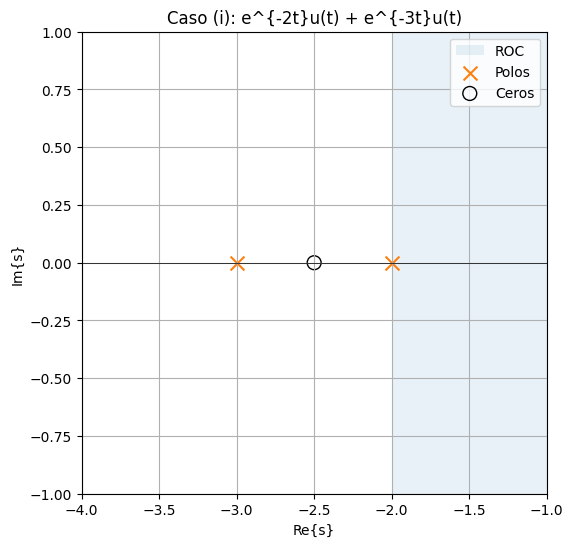

In [ ]:
# Caso (i): e^{-2t}u(t) + e^{-3t}u(t)
poles_i = [-2 + 0j, -3 + 0j]
zeros_i = [-2.5 + 0j]

plot_pz_roc(
    poles=poles_i,
    zeros=zeros_i,
    roc_type="right",
    roc_params={"sigma0": -2},
    title="Caso (i): e^{-2t}u(t) + e^{-3t}u(t)"
)


###Caso (b)

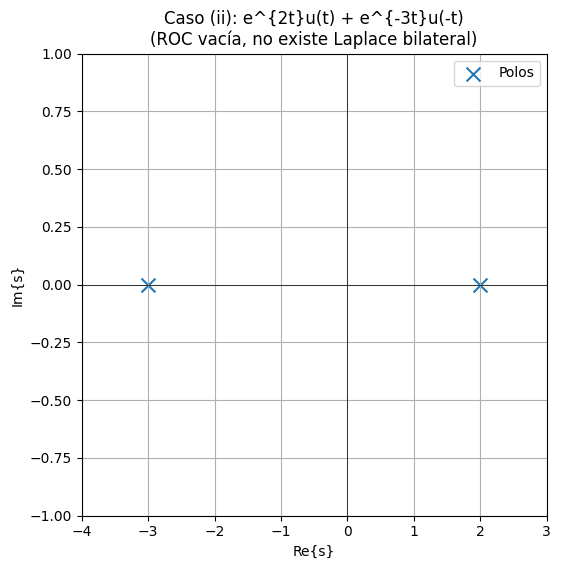

In [ ]:
# Caso (ii): e^{2t}u(t) + e^{-3t}u(-t)
poles_ii = [2 + 0j, -3 + 0j]
zeros_ii = []  # sin ceros

# No sombreo ROC porque es vacía (no hay región que sirva)
plot_pz_roc(
    poles=poles_ii,
    zeros=zeros_ii,
    roc_type=None,
    roc_params=None,
    title="Caso (ii): e^{2t}u(t) + e^{-3t}u(-t)\n(ROC vacía, no existe Laplace bilateral)"
)


###Caso (c)

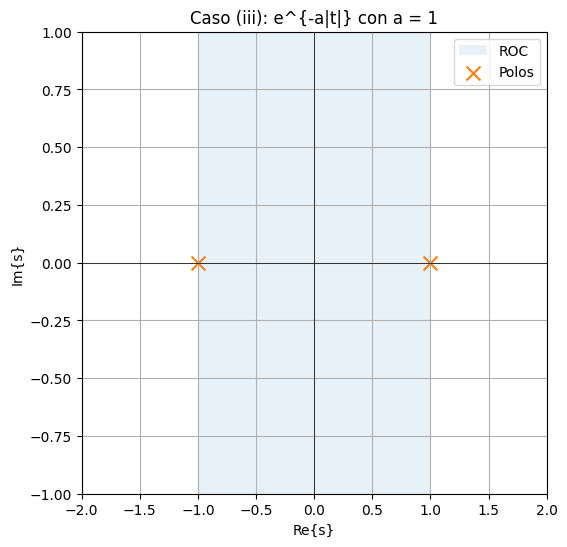

In [ ]:
# Caso (iii): e^{-a|t|}, elegimos a = 1
a = 1.0
poles_iii = [a + 0j, -a + 0j]
zeros_iii = []

plot_pz_roc(
    poles=poles_iii,
    zeros=zeros_iii,
    roc_type="strip",
    roc_params={"sigma1": -a, "sigma2": a},
    title="Caso (iii): e^{-a|t|} con a = 1"
)


###Caso (d)

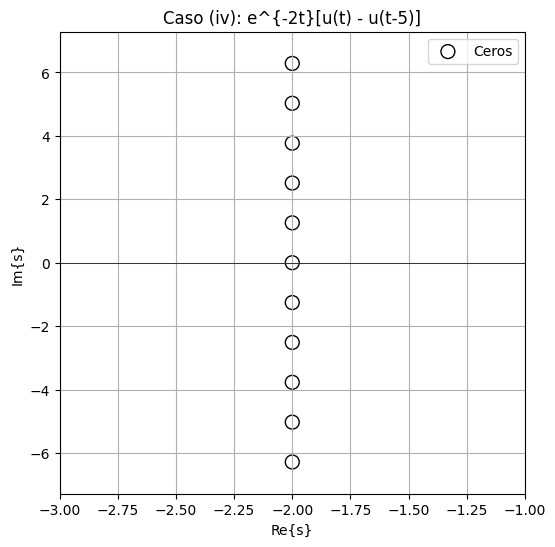

In [ ]:
# Caso (iv): e^{-2t}[u(t) - u(t-5)]

# Ceros en s_k = -2 - j * 2πk/5
ks = np.arange(-5, 6)  # k = -5,...,5
zeros_iv = [-2 - 1j * 2*np.pi*k/5 for k in ks]

poles_iv = []  # el polo en s=-2 queda cancelado

plot_pz_roc(
    poles=poles_iv,
    zeros=zeros_iv,
    roc_type="full",  # ROC = todo el plano; no sombreamos nada especial
    roc_params=None,
    title="Caso (iv): e^{-2t}[u(t) - u(t-5)]"
)


---
###**2.10 Transformada Inversa de Laplace**

Sea

$$
X(s) = \frac{1}{(s+1)(s+2)^2}, \qquad \Re\{s\} \ge -1.
$$

Queremos encontrar $x(t)$ tal que

$$
\mathcal{L}\{x(t)\} = X(s).
$$


### Descomposición en fracciones parciales

Buscamos constantes $A,B,C$ tales que

$$
\frac{1}{(s+1)(s+2)^2}
= \frac{A}{s+1} + \frac{B}{s+2} + \frac{C}{(s+2)^2}.
$$

Multiplicando ambos lados por $(s+1)(s+2)^2$:

$$
1 = A(s+2)^2 + B(s+1)(s+2) + C(s+1).
$$

Desarrollamos:

- $(s+2)^2 = s^2 + 4s + 4$,
- $(s+1)(s+2) = s^2 + 3s + 2$.

Entonces

$$
\begin{aligned}
1 &= A(s^2 + 4s + 4)
   + B(s^2 + 3s + 2)
   + C(s+1) \\
  &= (A+B)s^2 + (4A + 3B + C)s + (4A + 2B + C).
\end{aligned}
$$

Igualamos con el polinomio constante $1$:

$$
1 = 0\cdot s^2 + 0\cdot s + 1,
$$

y por tanto obtenemos el sistema:

$$
\begin{cases}
A + B = 0, \\
4A + 3B + C = 0, \\
4A + 2B + C = 1.
\end{cases}
$$

De la primera ecuación:

$$
B = -A.
$$

Sustituimos en las otras dos:

1. Segunda ecuación:

$$
4A + 3(-A) + C = 0
\;\Rightarrow\;
A + C = 0
\;\Rightarrow\;
C = -A.
$$

2. Tercera ecuación:

$$
4A + 2(-A) + C = 1
\;\Rightarrow\;
2A + C = 1.
$$

Como $C = -A$, tenemos:

$$
2A - A = 1 \;\Rightarrow\; A = 1.
$$

Entonces

$$
B = -1, \qquad C = -1.
$$

Por lo tanto,

$$
\frac{1}{(s+1)(s+2)^2}
= \frac{1}{s+1} - \frac{1}{s+2} - \frac{1}{(s+2)^2}.
$$

###Transformada inversa de cada término

Recordamos los pares básicos (para señales causales, con $u(t)$ el escalón unitario):

1.
$$
\mathcal{L}\{e^{-a t} u(t)\} = \frac{1}{s+a}.
$$

2.
$$
\mathcal{L}\{t\,e^{-a t} u(t)\} = \frac{1}{(s+a)^2}.
$$

Aplicando esto:

-
$$
\mathcal{L}^{-1}\left\{\frac{1}{s+1}\right\}
= e^{-t} u(t),
$$

-
$$
\mathcal{L}^{-1}\left\{-\frac{1}{s+2}\right\}
= -e^{-2t} u(t),
$$

-
$$
\mathcal{L}^{-1}\left\{-\frac{1}{(s+2)^2}\right\}
= -t e^{-2t} u(t).
$$

Sumando los tres términos:

$$
x(t) = e^{-t} u(t) - e^{-2t} u(t) - t e^{-2t} u(t).
$$

Podemos factorizar $u(t)$:

$$
\boxed{
x(t) = \big(e^{-t} - e^{-2t} - t e^{-2t}\big)\,u(t).
}
$$

Esta es la transformada inversa de Laplace de

$$
X(s) = \frac{1}{(s+1)(s+2)^2},
$$

con la región de convergencia $\Re\{s\} \ge -1$, lo que corresponde a una señal causal (multiplicada por $u(t)$).


###Comprobación con SymPy

In [ ]:
import sympy as sp

t, s = sp.symbols('t s', real=True)
X = 1 / ((s + 1) * (s + 2)**2)

# Transformada inversa de Laplace
x_t = sp.inverse_laplace_transform(X, s, t)
sp.simplify(x_t)


(-t + exp(t) - 1)*exp(-2*t)*Heaviside(t)

---
###**2.11Autofunciones y SLITs**

Se considera el sistema lineal e invariante en el tiempo (SLIT) descrito por la EDO:

$$
a_0 y(t) + a_1 \frac{dy(t)}{dt} + a_2 \frac{d^2 y(t)}{dt^2} = x(t),
$$

con $a_i \in \mathbb{R}$ para todo $i$.

Tomamos como entrada una exponencial compleja de la forma

$$
x(t) = e^{s t}, \quad s \in \mathbb{C}.
$$

Se busca la salida $y(t)$ asociada a esta entrada, descartando las constantes de integración (es decir, ignorando la respuesta natural y quedándonos solo con la respuesta forzada).


###Solución particular para entrada $x(t) = e^{s t}$

Proponemos una solución particular de la forma

$$
y_p(t) = \lambda e^{s t},
$$

donde $\lambda$ es una constante (compleja, en general).

Calculamos las derivadas:

$$
\frac{dy_p}{dt} = \lambda s e^{s t}, \qquad
\frac{d^2 y_p}{dt^2} = \lambda s^2 e^{s t}.
$$

Sustituimos en la EDO:

$$
a_0 y_p(t) + a_1 \frac{dy_p}{dt} + a_2 \frac{d^2 y_p}{dt^2}
= x(t) = e^{s t}.
$$

Es decir:

$$
a_0 (\lambda e^{s t}) + a_1 (\lambda s e^{s t}) + a_2 (\lambda s^2 e^{s t}) = e^{s t}.
$$

Factorizamos $\lambda e^{s t}$:

$$
\lambda e^{s t} \big(a_0 + a_1 s + a_2 s^2\big) = e^{s t}.
$$

Como $e^{s t} \neq 0$, podemos simplificar:

$$
\lambda \big(a_0 + a_1 s + a_2 s^2\big) = 1,
$$

de donde

$$
\boxed{
\lambda = \frac{1}{a_0 + a_1 s + a_2 s^2}.
}
$$

Por lo tanto, la solución particular queda como

$$
y_p(t) = \lambda e^{s t}
= \frac{e^{s t}}{a_0 + a_1 s + a_2 s^2}.
$$

Si suponemos condiciones iniciales cero (sistema inicialmente en reposo), la salida total coincide con esta solución particular:

$$
\boxed{
y(t) = \frac{e^{s t}}{a_0 + a_1 s + a_2 s^2}.
}
$$

###Interpretación de $\lambda$

Para la entrada $x(t) = e^{s t}$, la salida (sin respuesta natural) es

$$
y(t) = \lambda e^{s t},
$$

con

$$
\lambda = \frac{1}{a_0 + a_1 s + a_2 s^2}.
$$

Esto muestra que:

- $e^{s t}$ es una **autofunción** del sistema SLIT.
- $\lambda$ es el **autovalor** asociado a ese modo exponencial.

En términos de función de transferencia $H(s)$, para condiciones iniciales cero:

$$
H(s) = \frac{Y(s)}{X(s)}.
$$

Para una entrada $x(t) = e^{s t}$, se tiene $X(s)$ concentrada en ese modo y la salida es $y(t) = \lambda e^{s t}$, por lo que la ganancia compleja es justamente

$$
\boxed{
H(s) = \lambda = \frac{1}{a_0 + a_1 s + a_2 s^2}.
}
$$

Es decir, $\lambda$ es la **respuesta en frecuencia generalizada** del sistema (la función de transferencia) evaluada en $s$.


### Generalización a una EDO de orden arbitrario

Consideremos ahora una EDO de orden $N$:

$$
\sum_{k=0}^{N} a_k \frac{d^k y(t)}{dt^k} = x(t),
$$

con $a_k \in \mathbb{R}$ (o $\mathbb{C}$).

Tomamos de nuevo como entrada

$$
x(t) = e^{s t}.
$$

Proponemos una solución particular

$$
y_p(t) = \lambda e^{s t}.
$$

Entonces

$$
\frac{d^k y_p}{dt^k} = \lambda s^k e^{s t}, \qquad k = 0,1,\dots,N.
$$

Sustituimos en la EDO:

$$
\sum_{k=0}^{N} a_k \frac{d^k y_p}{dt^k}
= \sum_{k=0}^{N} a_k \big(\lambda s^k e^{s t}\big)
= \lambda e^{s t} \sum_{k=0}^{N} a_k s^k
= x(t) = e^{s t}.
$$

Dividiendo por $e^{s t}$:

$$
\lambda \sum_{k=0}^{N} a_k s^k = 1,
$$

de donde

$$
\boxed{
\lambda = \frac{1}{\displaystyle \sum_{k=0}^{N} a_k s^k}.
}
$$

Por tanto, la solución particular es

$$
y_p(t) = \lambda e^{s t}
= \frac{e^{s t}}{\displaystyle \sum_{k=0}^{N} a_k s^k}.
$$

Con condiciones iniciales cero:

$$
\boxed{
y(t) = \frac{e^{s t}}{\displaystyle \sum_{k=0}^{N} a_k s^k}.
}
$$

La función de transferencia del sistema queda entonces

$$
\boxed{
H(s) = \frac{1}{\displaystyle \sum_{k=0}^{N} a_k s^k}.
}
$$

### Respuestas directas a las preguntas

1. **¿Qué relación tiene $\lambda$ con la salida obtenida al resolver la EDO?**

   Para una entrada $x(t) = e^{s t}$, la salida (con condiciones iniciales cero) es

   $$
   y(t) = \lambda e^{s t},
   $$

   con

   $$
   \lambda = \frac{1}{a_0 + a_1 s + a_2 s^2}
   $$

   en el caso de segundo orden. Es decir, $\lambda$ es la **ganancia compleja** (autovalor) del sistema para el modo exponencial $e^{s t}$, o equivalentemente, la función de transferencia $H(s)$ del sistema.

2. **¿Se puede generalizar a una EDO de orden arbitrario?**

   Sí. Para la EDO

   $$
   \sum_{k=0}^{N} a_k \frac{d^k y(t)}{dt^k} = x(t),
   $$

   la entrada $x(t) = e^{s t}$ produce una salida

   $$
   y(t) = \lambda e^{s t},
   \quad
   \lambda = \frac{1}{\displaystyle \sum_{k=0}^{N} a_k s^k},
   $$

   de modo que la función de transferencia general es

   $$
   H(s) = \frac{1}{\displaystyle \sum_{k=0}^{N} a_k s^k}.
   $$

En todos los casos, la exponencial compleja $e^{s t}$ es autofunción del SLIT y $\lambda$ es su autovalor asociado.



---
###**2.12 Circuito RLC serie – función de transferencia $V_C(s)/V_{\text{in}}(s)$**

### Planteamiento

Circuito RLC **serie** con:

- Entrada: tensión de alimentación $v_{\text{in}}(t)$
- Salida: tensión en el capacitor $v_C(t)$
- Elementos: $R$, $L$, $C$ en serie
- Corriente en la rama: $i(t)$ (misma en $R$, $L$ y $C$)

Por KVL:

$$
v_{\text{in}}(t) = v_R(t) + v_L(t) + v_C(t).
$$

Con las relaciones constitutivas:

$$
v_R(t) = R\,i(t), \qquad
v_L(t) = L\,\frac{di(t)}{dt}, \qquad
i_C(t) = i(t) = C\,\frac{dv_C(t)}{dt}.
$$

Entonces

$$
i(t) = C\,\frac{dv_C(t)}{dt}.
$$

Sustituimos en $v_R$ y $v_L$:

$$
v_R(t) = R\,C\,\frac{dv_C(t)}{dt}, \qquad
v_L(t) = L\,C\,\frac{d^2 v_C(t)}{dt^2}.
$$

KVL queda:

$$
v_{\text{in}}(t) = R C \frac{dv_C(t)}{dt} + L C \frac{d^2 v_C(t)}{dt^2} + v_C(t).
$$

Reordenando:

$$
L C \frac{d^2 v_C(t)}{dt^2} + R C \frac{dv_C(t)}{dt} + v_C(t) = v_{\text{in}}(t).
$$



### Ecuación en Laplace con condiciones iniciales

Aplicamos transformada de Laplace (bilateral) suponiendo que:

- $v_C(0^-) = v_{C0}$,
- $\dfrac{dv_C}{dt}\big|_{t=0^-} = \dot{v}_{C0}$.

Usamos:

$$
\mathcal{L}\left\{\frac{dv_C}{dt}\right\}
= s V_C(s) - v_{C0},
$$

$$
\mathcal{L}\left\{\frac{d^2 v_C}{dt^2}\right\}
= s^2 V_C(s) - s v_{C0} - \dot{v}_{C0}.
$$

Aplicando a la EDO:

$$
L C \left[s^2 V_C(s) - s v_{C0} - \dot{v}_{C0}\right]
+ R C \left[s V_C(s) - v_{C0}\right]
+ V_C(s)
= V_{\text{in}}(s).
$$

Agrupamos términos en $V_C(s)$:

$$
\big(L C s^2 + R C s + 1\big) V_C(s)
- L C \big(s v_{C0} + \dot{v}_{C0}\big)
- R C v_{C0}
= V_{\text{in}}(s).
$$

Pasamos los términos de condiciones iniciales al otro lado:

$$
\big(L C s^2 + R C s + 1\big) V_C(s)
= V_{\text{in}}(s)
+ L C \big(s v_{C0} + \dot{v}_{C0}\big)
+ R C v_{C0}.
$$

###Función de transferencia (condiciones iniciales cero)

La **función de transferencia** se define con **energías iniciales nulas**:

$$
v_{C0} = 0, \qquad \dot{v}_{C0} = 0.
$$

En ese caso:

$$
\big(L C s^2 + R C s + 1\big) V_C(s) = V_{\text{in}}(s),
$$

luego

$$
\boxed{
H_{\text{serie}}(s)
= \frac{V_C(s)}{V_{\text{in}}(s)}
= \frac{1}{L C s^2 + R C s + 1}.
}
$$

(Esto coincide con hacer división de tensiones en el dominio $s$ usando impedancias.)

## Circuito RLC en paralelo – función de transferencia $I_L(s)/I_{\text{in}}(s)$

Ahora consideramos un circuito RLC **en paralelo**:

- Rama $R$, rama $L$, rama $C$ en paralelo.
- Entrada: fuente de corriente $i_{\text{in}}(t)$ que alimenta el nodo.
- Salida: corriente por el inductor $i_L(t)$.
- Tensión en el nodo: $v(t)$ (misma en las tres ramas).

Relaciones:

$$
i_R(t) = \frac{v(t)}{R}, \quad
i_C(t) = C \frac{dv(t)}{dt}, \quad
v(t) = L \frac{di_L(t)}{dt}.
$$

La ecuación de KCL en el nodo:

$$
i_{\text{in}}(t) = i_R(t) + i_C(t) + i_L(t).
$$

Sustituimos en términos de $i_L(t)$ usando $v(t) = L \dfrac{di_L}{dt}$:

- $i_R(t) = \dfrac{v(t)}{R} = \dfrac{L}{R} \dfrac{di_L}{dt}$,
- $i_C(t) = C \dfrac{dv}{dt} = C \dfrac{d}{dt}\left(L \dfrac{di_L}{dt}\right) = L C \dfrac{d^2 i_L}{dt^2}$.

Entonces:

$$
i_{\text{in}}(t)
= L C \frac{d^2 i_L(t)}{dt^2}
+ \frac{L}{R} \frac{d i_L(t)}{dt}
+ i_L(t).
$$

Reordenando:

$$
L C \frac{d^2 i_L(t)}{dt^2}
+ \frac{L}{R} \frac{d i_L(t)}{dt}
+ i_L(t)
= i_{\text{in}}(t).
$$

###Ecuación en Laplace con condiciones iniciales

Sea:

- $i_L(0^-) = i_{L0}$,
- $\dfrac{di_L}{dt}\big|_{t=0^-} = \dot{i}_{L0}$.

Aplicamos Laplace:

$$
\mathcal{L}\left\{\frac{di_L}{dt}\right\}
= s I_L(s) - i_{L0},
$$

$$
\mathcal{L}\left\{\frac{d^2 i_L}{dt^2}\right\}
= s^2 I_L(s) - s i_{L0} - \dot{i}_{L0}.
$$

Entonces:

$$
L C \left[s^2 I_L(s) - s i_{L0} - \dot{i}_{L0}\right]
+ \frac{L}{R} \left[s I_L(s) - i_{L0}\right]
+ I_L(s)
= I_{\text{in}}(s).
$$

Agrupamos términos en $I_L(s)$:

$$
\big(L C s^2 + \frac{L}{R} s + 1\big) I_L(s)
- L C \big(s i_{L0} + \dot{i}_{L0}\big)
- \frac{L}{R} i_{L0}
= I_{\text{in}}(s).
$$

Pasamos las condiciones iniciales al otro lado:

$$
\big(L C s^2 + \frac{L}{R} s + 1\big) I_L(s)
= I_{\text{in}}(s)
+ L C \big(s i_{L0} + \dot{i}_{L0}\big)
+ \frac{L}{R} i_{L0}.
$$

### Función de transferencia (condiciones iniciales cero)

Definimos la función de transferencia con:

$$
i_{L0} = 0, \qquad \dot{i}_{L0} = 0.
$$

Entonces:

$$
\big(L C s^2 + \frac{L}{R} s + 1\big) I_L(s) = I_{\text{in}}(s),
$$

por lo que

$$
\boxed{
H_{\text{paralelo}}(s)
= \frac{I_L(s)}{I_{\text{in}}(s)}
= \frac{1}{L C s^2 + \dfrac{L}{R} s + 1}.
}
$$

(Lo mismo se obtiene haciendo división de corrientes en el dominio $s$ usando admitancias.)

##Comentario final

- En ambos casos (serie y paralelo) aparecen ecuaciones de **segundo orden** con la misma estructura:

  - Serie (salida tensión de $C$):
    $$
    H_{\text{serie}}(s)
    = \frac{1}{L C s^2 + R C s + 1}.
    $$

  - Paralelo (salida corriente de $L$):
    $$
    H_{\text{paralelo}}(s)
    = \frac{1}{L C s^2 + \dfrac{L}{R} s + 1}.
    $$

- Las **condiciones iniciales** no afectan la función de transferencia, pero sí la **respuesta total** (aparecen como términos adicionales en el numerador cuando escribes $Y(s)$ en función de la entrada y las energías iniciales). Para definir $H(s)$ siempre se asume que las energías iniciales son cero (sistema inicialmente en reposo).


---
###**2.13**

## 1. Recordatorio: lazo abierto y lazo cerrado

En el punto anterior teníamos, para ambos circuitos, funciones de transferencia **en lazo abierto** de la forma

$$
H(s) = \frac{1}{L C s^2 + \alpha s + 1},
$$

donde:

- Para el **RLC serie (salida tensión en C)**:
  $$
  \alpha_{\text{serie}} = R C.
  $$

- Para el **RLC en paralelo (salida corriente en L)**:
  $$
  \alpha_{\text{paralelo}} = \frac{L}{R}.
  $$

Si ponemos el sistema en lazo cerrado con **realimentación unitaria**:

$$
T(s) = \frac{H(s)}{1 + H(s)},
$$

obtenemos:

$$
T(s) = \frac{\dfrac{1}{L C s^2 + \alpha s + 1}}{1 + \dfrac{1}{L C s^2 + \alpha s + 1}}
= \frac{1}{L C s^2 + \alpha s + 2}.
$$

Así que, en lazo cerrado, la función de transferencia (entrada–salida) es

$$
\boxed{
T(s) = \frac{1}{L C s^2 + \alpha s + 2}
}
$$

tanto para el circuito serie como para el paralelo, cambiando el valor de $\alpha$ según el caso.

---

## 2. Notación: raíces del denominador

Definimos las raíces del denominador de lazo cerrado:

$$
L C s^2 + \alpha s + 2 = 0
\quad\Longrightarrow\quad
s_{1,2} = \frac{-\alpha \pm \sqrt{\alpha^2 - 8 L C}}{2 L C}.
$$

Y factorizamos:

$$
L C s^2 + \alpha s + 2 = L C (s - s_1)(s - s_2).
$$

Entonces

$$
T(s) = \frac{1}{L C (s - s_1)(s - s_2)}.
$$

Todo lo que viene lo escribo en términos de $s_1,s_2$; luego basta sustituirlos con la fórmula de arriba (y $\alpha$ en función de $R,L,C$).

---

## 3. Entrada impulso: $r(t) = \delta(t)$

Transformada de Laplace:

$$
R_{\delta}(s) = 1.
$$

La salida en el dominio $s$ es

$$
Y_{\delta}(s) = T(s) = \frac{1}{L C (s - s_1)(s - s_2)}.
$$

Hacemos fracciones parciales:

$$
\frac{1}{(s - s_1)(s - s_2)}
= \frac{1}{s_1 - s_2}\left( \frac{1}{s - s_1} - \frac{1}{s - s_2} \right).
$$

Por tanto:

$$
Y_{\delta}(s)
= \frac{1}{L C (s_1 - s_2)}
\left( \frac{1}{s - s_1} - \frac{1}{s - s_2} \right).
$$

Aplicando transformada inversa:

$$
\boxed{
y_{\delta}(t)
= \frac{1}{L C (s_1 - s_2)}\big( e^{s_1 t} - e^{s_2 t} \big)\,u(t).
}
$$

Esta es la **respuesta al impulso** en lazo cerrado.

---

## 4. Entrada escalón unitario: $r(t) = u(t)$

Transformada de Laplace:

$$
R_u(s) = \frac{1}{s}.
$$

Entonces

$$
Y_u(s) = \frac{T(s)}{s}
= \frac{1}{s}\,\frac{1}{L C (s - s_1)(s - s_2)}.
$$

Escribimos

$$
Y_u(s) = \frac{A}{s} + \frac{B}{s - s_1} + \frac{C}{s - s_2}.
$$

En lugar de resolver desde cero, aprovechamos una descomposición algo más estructurada.

Partimos de

$$
T(s) = \frac{1}{L C (s - s_1)(s - s_2)}
$$

y escribimos

$$
\frac{T(s)}{s}
= \frac{1}{L C (s_1 - s_2)}\left[ \frac{1}{s(s - s_1)} - \frac{1}{s(s - s_2)} \right].
$$

Sabemos que

$$
\frac{1}{s(s - a)} = -\frac{1}{a}\frac{1}{s} + \frac{1}{a}\frac{1}{s - a}.
$$

Aplicamos con $a = s_1$ y $a = s_2$:

- Para $a = s_1$:

  $$
  \frac{1}{s(s - s_1)} = -\frac{1}{s_1}\frac{1}{s} + \frac{1}{s_1}\frac{1}{s - s_1}.
  $$

- Para $a = s_2$:

  $$
  \frac{1}{s(s - s_2)} = -\frac{1}{s_2}\frac{1}{s} + \frac{1}{s_2}\frac{1}{s - s_2}.
  $$

Entonces

$$
\begin{aligned}
Y_u(s)
&= \frac{1}{L C (s_1 - s_2)}
\Big[ \left(-\frac{1}{s_1}\frac{1}{s} + \frac{1}{s_1}\frac{1}{s - s_1}\right)
      - \left(-\frac{1}{s_2}\frac{1}{s} + \frac{1}{s_2}\frac{1}{s - s_2}\right)
\Big] \\[4pt]
&= \frac{1}{L C (s_1 - s_2)}
\Big[ \left(-\frac{1}{s_1} + \frac{1}{s_2}\right)\frac{1}{s}
      + \frac{1}{s_1}\frac{1}{s - s_1}
      - \frac{1}{s_2}\frac{1}{s - s_2}
\Big].
\end{aligned}
$$

Observa que

$$
-\frac{1}{s_1} + \frac{1}{s_2}
= \frac{s_1 - s_2}{s_1 s_2}.
$$

Por tanto

$$
Y_u(s)
= \underbrace{\frac{1}{L C s_1 s_2}}_{A}\frac{1}{s}
+ \underbrace{\frac{1}{L C s_1 (s_1 - s_2)}}_{B}\frac{1}{s - s_1}
+ \underbrace{-\frac{1}{L C s_2 (s_1 - s_2)}}_{C}\frac{1}{s - s_2}.
$$

Sabemos que, para un polinomio cuadrático $L C s^2 + \alpha s + 2$,

$$
s_1 s_2 = \frac{2}{L C}.
$$

Luego

$$
A = \frac{1}{L C \cdot s_1 s_2}
= \frac{1}{L C \cdot \dfrac{2}{L C}}
= \frac{1}{2}.
$$

Así:

$$
\boxed{
Y_u(s)
= \frac{1}{2}\frac{1}{s}
+ \frac{1}{L C s_1 (s_1 - s_2)}\frac{1}{s - s_1}
- \frac{1}{L C s_2 (s_1 - s_2)}\frac{1}{s - s_2}.
}
$$

Transformada inversa:

$$
\boxed{
y_u(t)
= \left[
\frac{1}{2}
+ \frac{1}{L C s_1 (s_1 - s_2)} e^{s_1 t}
- \frac{1}{L C s_2 (s_1 - s_2)} e^{s_2 t}
\right] u(t).
}
$$

Esa es la **respuesta al escalón** en lazo cerrado.

---

## 5. Entrada rampa: $r(t) = t\,u(t)$

Transformada de Laplace:

$$
R_{\text{rampa}}(s) = \frac{1}{s^2}.
$$

Entonces

$$
Y_{\text{rampa}}(s) = \frac{T(s)}{s^2}
= \frac{1}{s^2}\cdot \frac{1}{L C (s - s_1)(s - s_2)}.
$$

Podemos hacer fracciones parciales de modo que

$$
Y_{\text{rampa}}(s)
= \frac{K_1}{s^2} + \frac{K_2}{s}
+ \frac{D_1}{s - s_1} + \frac{D_2}{s - s_2}.
$$

Si haces la descomposición sistemática (o te ayudas con SymPy), obtienes:

- Producto de raíces:
  $$
  s_1 s_2 = \frac{2}{L C}, \qquad
  s_1 + s_2 = -\frac{\alpha}{L C}.
  $$

- Coeficientes:

  $$
  K_1 = \frac{1}{L C s_1 s_2} = \frac{1}{2},
  $$

  $$
  K_2 = \frac{s_1 + s_2}{L C s_1^2 s_2^2} = -\frac{\alpha}{4},
  $$

  $$
  D_1 = \frac{1}{L C\, s_1^2 (s_1 - s_2)},
  \qquad
  D_2 = -\frac{1}{L C\, s_2^2 (s_1 - s_2)}.
  $$

Entonces

$$
\boxed{
Y_{\text{rampa}}(s)
= \frac{1/2}{s^2}
- \frac{\alpha}{4}\,\frac{1}{s}
+ \frac{1}{L C\, s_1^2 (s_1 - s_2)}\frac{1}{s - s_1}
- \frac{1}{L C\, s_2^2 (s_1 - s_2)}\frac{1}{s - s_2}.
}
$$

Aplicando la inversa:

- $\mathcal{L}^{-1}\{1/s^2\} = t\,u(t)$,
- $\mathcal{L}^{-1}\{1/s\} = u(t)$,
- $\mathcal{L}^{-1}\{1/(s - s_i)\} = e^{s_i t}u(t)$.

Por tanto:

$$
\boxed{
y_{\text{rampa}}(t)
= \left[
\frac{1}{2}\,t
- \frac{\alpha}{4}
+ \frac{1}{L C\, s_1^2 (s_1 - s_2)} e^{s_1 t}
- \frac{1}{L C\, s_2^2 (s_1 - s_2)} e^{s_2 t}
\right] u(t).
}
$$

Se ve que el sistema es de tipo $0$ (no tiene integrador), así que frente a rampa la salida crece aproximadamente como $t/2$; el resto son transitorios exponenciales.

---

## 6. Sustituir para cada circuito

Recuerda:

- **RLC serie (salida $v_C$)**:
  $$
  \alpha = R C.
  $$

- **RLC paralelo (salida $i_L$)**:
  $$
  \alpha = \frac{L}{R}.
  $$

En cada caso:

1. Calculas $s_1,s_2$ con
   $$
   s_{1,2} = \frac{-\alpha \pm \sqrt{\alpha^2 - 8 L C}}{2 L C}.
   $$
2. Metes esos $s_1,s_2$ en las expresiones de $y_\delta(t)$, $y_u(t)$ y $y_{\text{rampa}}(t)$.

Eso te deja las respuestas explícitas en función de $R,L,C$.

---

## 7. Comprobación y gráficas en Python/SymPy

Aquí tienes un código para Colab que:

1. Define $T(s)$ genérico para ambos circuitos (serie/paralelo).
2. Calcula la respuesta a impulso, escalón y rampa con `inverse_laplace_transform`.
3. Sustituye valores numéricos (por ejemplo $R=L=C=1$) y grafica las salidas.




In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Activar pretty printing
sp.init_printing()

# Símbolos
t, s = sp.symbols('t s', real=True)
R, L, C = sp.symbols('R L C', positive=True)

# Parámetros alpha para cada caso
alpha_series   = R * C       # RLC serie
alpha_parallel = L / R       # RLC paralelo

def closed_loop_T(alpha):
    """Función de transferencia lazo cerrado T(s) = 1 / (L C s^2 + alpha s + 2)."""
    return 1 / (L*C*s**2 + alpha*s + 2)

# T(s) lazo cerrado para serie y paralelo
T_series   = closed_loop_T(alpha_series)
T_parallel = closed_loop_T(alpha_parallel)

def time_responses(Ts):
    """Devuelve y_imp(t), y_step(t), y_ramp(t) simbólicos para una T(s) dada."""
    Y_imp  = Ts                 # entrada impulso: R(s) = 1
    Y_step = Ts / s             # entrada escalón: R(s) = 1/s
    Y_ramp = Ts / s**2          # entrada rampa:  R(s) = 1/s^2

    y_imp_t  = sp.simplify(sp.inverse_laplace_transform(Y_imp,  s, t))
    y_step_t = sp.simplify(sp.inverse_laplace_transform(Y_step, s, t))
    y_ramp_t = sp.simplify(sp.inverse_laplace_transform(Y_ramp, s, t))

    return y_imp_t, y_step_t, y_ramp_t

# Respuestas simbólicas (aún con R,L,C)
y_imp_series,   y_step_series,   y_ramp_series   = time_responses(T_series)
y_imp_parallel, y_step_parallel, y_ramp_parallel = time_responses(T_parallel)

print("Respuesta al impulso (serie):")
sp.pprint(y_imp_series)
print("\nRespuesta al escalón (serie):")
sp.pprint(y_step_series)
print("\nRespuesta a rampa (serie):")
sp.pprint(y_ramp_series)


Respuesta al impulso (serie):
   -R⋅t     ⎛     ______________⎞     
   ─────    ⎜    ╱      2       ⎟     
    2⋅L     ⎜t⋅╲╱  - C⋅R  + 8⋅L ⎟     
2⋅ℯ     ⋅sin⎜───────────────────⎟⋅θ(t)
            ⎝      2⋅√C⋅L       ⎠     
──────────────────────────────────────
               ______________         
              ╱      2                
         √C⋅╲╱  - C⋅R  + 8⋅L          

Respuesta al escalón (serie):
        -R⋅t     ⎛     ______________⎞                -R⋅t     ⎛     _________ ↪
        ─────    ⎜    ╱      2       ⎟                ─────    ⎜    ╱      2   ↪
         2⋅L     ⎜t⋅╲╱  - C⋅R  + 8⋅L ⎟                 2⋅L     ⎜t⋅╲╱  - C⋅R  + ↪
  √C⋅R⋅ℯ     ⋅sin⎜───────────────────⎟⋅θ(t)          ℯ     ⋅cos⎜────────────── ↪
                 ⎝      2⋅√C⋅L       ⎠        θ(t)             ⎝      2⋅√C⋅L   ↪
- ───────────────────────────────────────── + ──── - ───────────────────────── ↪
                  ______________               2                      2        ↪
                 ╱   

---
###**2.14**

## 1. Sistema de segundo orden y tipos de amortiguamiento

La forma canónica (denominador) de un sistema lineal de segundo orden es

$$
G(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2},
$$

donde:

- $\omega_n$ = frecuencia natural no amortiguada (rad/s),
- $\zeta$ = factor de amortiguamiento (adimensional).

Las raíces del denominador son:

$$
s_{1,2} = -\zeta\omega_n \pm j\,\omega_d,
\quad
\omega_d = \omega_n\sqrt{1 - \zeta^2}
$$

(para $0<\zeta<1$).

### Tipos de amortiguamiento

- **Subamortiguado**: $0 < \zeta < 1$  
  Polos complejos conjugados con parte real negativa. Respuesta oscilatoria amortiguada, sobreimpulso.

- **Amortiguamiento crítico**: $\zeta = 1$  
  Polos reales e iguales. Respuesta más rápida posible sin sobreimpulso.

- **Sobreamortiguado**: $\zeta > 1$  
  Polos reales, distintos, negativos. Sin oscilaciones, pero más lento que el crítico.

- **Inestable**: al menos un polo con parte real positiva.  
  En la forma canónica, típicamente $\zeta < 0$ o $\omega_n^2 < 0$ ⇒ crecimiento exponencial.

---

## 2. Circuitos RLC serie y paralelo (lazo abierto)

De antes:

- **RLC serie** (entrada tensión $v_\text{in}$, salida tensión en el capacitor $v_C$):

  $$
  L C \frac{d^2 v_C}{dt^2} + R C \frac{dv_C}{dt} + v_C = v_\text{in}(t),
  $$

  con función de transferencia en lazo abierto

  $$
  H_\text{serie}(s) = \frac{V_C(s)}{V_\text{in}(s)}
  = \frac{1}{L C s^2 + R C s + 1}.
  $$

- **RLC paralelo** (entrada corriente $i_\text{in}$, salida corriente en el inductor $i_L$):

  $$
  L C \frac{d^2 i_L}{dt^2} + \frac{L}{R}\frac{d i_L}{dt} + i_L = i_\text{in}(t),
  $$

  con función de transferencia

  $$
  H_\text{par}(s) = \frac{I_L(s)}{I_\text{in}(s)}
  = \frac{1}{L C s^2 + \frac{L}{R} s + 1}.
  $$

Dividimos por $L C$ para llevar al formato canónico.

### 2.1. Denominadores normalizados

- Serie:

  $$
  H_\text{serie}(s) =
  \frac{1}{L C s^2 + R C s + 1}
  = \frac{\omega_n^2}{s^2 + \frac{R}{L} s + \omega_n^2},
  $$

  donde vamos a identificar $\omega_n^2 = \dfrac{1}{L C}$ más adelante.

- Paralelo:

  $$
  H_\text{par}(s) =
  \frac{1}{L C s^2 + \frac{L}{R} s + 1}
  = \frac{\omega_n^2}{s^2 + \frac{1}{R C} s + \omega_n^2}.
  $$

Comparamos cada denominador con el canónico:

$$
s^2 + 2\zeta\omega_n s + \omega_n^2.
$$

En ambos casos la parte constante es la misma, así que:

$$
\boxed{
\omega_n^2 = \frac{1}{L C}
\quad \Rightarrow \quad
\omega_n = \frac{1}{\sqrt{L C}}.
}
$$

### 2.2. Factor de amortiguamiento $\zeta$

- **RLC serie**:

  Denominador normalizado:

  $$
  s^2 + \frac{R}{L} s + \frac{1}{L C}.
  $$

  Igualando coeficiente de $s$:

  $$
  2\zeta\omega_n = \frac{R}{L}.
  $$

  Como $\omega_n = 1/\sqrt{L C}$:

  $$
  \zeta_\text{serie}
  = \frac{1}{2\omega_n}\frac{R}{L}
  = \frac{R}{2L} \sqrt{L C}
  = \frac{R}{2}\sqrt{\frac{C}{L}}.
  $$

  Es decir:

  $$
  \boxed{
  \zeta_\text{serie} = \frac{R}{2}\sqrt{\frac{C}{L}}.
  }
  $$

- **RLC paralelo**:

  Denominador normalizado:

  $$
  s^2 + \frac{1}{R C} s + \frac{1}{L C}.
  $$

  Igualamos:

  $$
  2\zeta\omega_n = \frac{1}{R C}.
  $$

  De nuevo $\omega_n = 1/\sqrt{L C}$:

  $$
  \zeta_\text{par}
  = \frac{1}{2\omega_n R C}
  = \frac{\sqrt{L C}}{2 R C}
  = \frac{1}{2 R}\sqrt{\frac{L}{C}}.
  $$

  Entonces:

  $$
  \boxed{
  \zeta_\text{paralelo} = \frac{1}{2 R}\sqrt{\frac{L}{C}}.
  }
  $$

### 2.3. Frecuencia natural amortiguada

Para ambos, si $0 < \zeta < 1$ (subamortiguado), la frecuencia natural amortiguada es

$$
\boxed{
\omega_d = \omega_n\sqrt{1 - \zeta^2}
= \frac{1}{\sqrt{L C}}\sqrt{1 - \zeta^2}.
}
$$

Esto vale tanto para el RLC serie como para el paralelo; sólo cambia cómo se relaciona $\zeta$ con $R,L,C$.

---

## 3. Diseño inverso: a partir de $\zeta$ y $\omega_n$ obtener R, L, C

Queremos usar el **formato canónico**:

$$
G(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}
$$

y hacer que coincida con el RLC físico. Para eso hacemos una elección simple:

- Fijamos un valor de referencia para $C$ (por ejemplo $C = 1\,$F).
- Calculamos $L$ a partir de $\omega_n$.
- Calculamos $R$ a partir de $\zeta$ y $\omega_n$.

### 3.1. Serie

Queremos que

$$
H_\text{serie}(s)
= \frac{1}{L C s^2 + R C s + 1}
$$

tenga el mismo denominador (hasta una constante) que

$$
\frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}.
$$

Si elegimos

$$
C = C_0,
$$

entonces la condición $\omega_n^2 = 1/(L C)$ da

$$
L = \frac{1}{\omega_n^2 C_0}.
$$

Por otro lado, al normalizar se cumple

$$
\frac{R}{L} = 2\zeta\omega_n
\quad \Rightarrow \quad
R = 2\zeta\omega_n L
= \frac{2\zeta}{\omega_n C_0}.
$$

Resumen serie:

$$
\boxed{
\begin{aligned}
C &= C_0, \\
L &= \frac{1}{\omega_n^2 C_0}, \\
R &= \frac{2\zeta}{\omega_n C_0}.
\end{aligned}
}
$$

Con esta elección, el circuito serie implementa exactamente el sistema de segundo orden con los parámetros $\zeta$ y $\omega_n$ escogidos.

### 3.2. Paralelo

Para el paralelo, el denominador normalizado es

$$
s^2 + \frac{1}{R C} s + \omega_n^2.
$$

Imponemos de nuevo $C = C_0$ y $\omega_n^2 = 1/(L C_0)$:

$$
L = \frac{1}{\omega_n^2 C_0}.
$$

Y de

$$
\frac{1}{R C_0} = 2\zeta\omega_n
\quad \Rightarrow \quad
R = \frac{1}{2\zeta\omega_n C_0}.
$$

Resumen paralelo:

$$
\boxed{
\begin{aligned}
C &= C_0, \\
L &= \frac{1}{\omega_n^2 C_0}, \\
R &= \frac{1}{2\zeta\omega_n C_0}.
\end{aligned}
}
$$

Con esto, el circuito paralelo también implementa el sistema de segundo orden con esos parámetros.



###Dashboard para simualción del sistema

In [ ]:
!pip install -q streamlit scipy matplotlib numpy
!mkdir -p pages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.9 MB/s eta 0:00:00


###Página principal

In [ ]:
%%writefile app.py
import streamlit as st

st.set_page_config(
    page_title="Bienvenida",
    page_icon="👋",
)

st.write("# Bienvenido al Dashboard de Sistemas RLC 👋")

st.sidebar.success("Selecciona una página en el menú lateral.")

st.markdown(
    r"""
    Esta aplicación permite simular sistemas de segundo orden
    equivalentes a circuitos RLC serie y paralelo.

    👉 Usa el menú de la izquierda para ir a **"⚡ RLC Dashboard"**.
    """
)


Writing app.py


###RLC

In [ ]:
%%writefile pages/1_⚡_RLC_Dashboard.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

st.set_page_config(page_title="RLC Dashboard", page_icon="⚡")

st.title("⚡ Dashboard de Sistemas RLC (Serie / Paralelo)")

st.markdown(
    r"""
    Sistema de segundo orden:

    $$
    G(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}.
    $$
    """
)

st.sidebar.header("Parámetros del sistema")

circuito = st.sidebar.selectbox("Tipo de circuito", ["Serie", "Paralelo"])
tipo_amort = st.sidebar.selectbox(
    "Tipo de amortiguamiento",
    ["Subamortiguado", "Sobreamortiguado", "Crítico", "Inestable"],
)

if tipo_amort == "Subamortiguado":
    zeta = st.sidebar.slider("Factor de amortiguamiento ζ", 0.01, 0.99, 0.3)
elif tipo_amort == "Sobreamortiguado":
    zeta = st.sidebar.slider("Factor de amortiguamiento ζ", 1.01, 5.0, 1.5)
elif tipo_amort == "Crítico":
    zeta = 1.0
    st.sidebar.info("Amortiguamiento crítico: ζ = 1 (fijado)")
else:
    zeta = st.sidebar.slider("Factor de amortiguamiento ζ", -2.0, -0.01, -0.3)

wn = st.sidebar.slider("Frecuencia natural no amortiguada ωₙ [rad/s]", 0.1, 50.0, 5.0)
C0 = st.sidebar.number_input(
    "Capacitancia C [F]", min_value=0.001, max_value=10.0, value=1.0, step=0.001
)

# Cálculo de R,L a partir de ζ, ωn y C
L = 1.0 / (wn**2 * C0)
if circuito == "Serie":
    R = 2.0 * zeta * wn * L
else:
    R = 1.0 / (2.0 * zeta * wn * C0)

st.subheader("Parámetros equivalentes del circuito RLC")
colR, colL, colC = st.columns(3)
colR.metric("R [Ω]", f"{R:.4g}")
colL.metric("L [H]", f"{L:.4g}")
colC.metric("C [F]", f"{C0:.4g}")

num = [wn**2]
den = [1.0, 2.0 * zeta * wn, wn**2]
sys = signal.TransferFunction(num, den)

poles = np.roots(den)
zeros = np.roots(num)

if abs(zeta) < 1:
    wd = wn * np.sqrt(1 - zeta**2)
else:
    wd = 0.0

st.markdown(
    rf"""
**ζ =** {zeta:.3f}
**ωₙ =** {wn:.3f} rad/s
**ω_d =** {wd:.3f} rad/s
"""
)

estable = np.all(poles.real < 0)

# Tiempo de simulación
if estable and zeta > 0:
    T_end = min(10.0 / (zeta * wn), 20.0)
else:
    T_end = 5.0 / max(wn, 1e-3)

t = np.linspace(0, T_end, 2000)

# Respuestas
t_imp, y_imp = signal.impulse(sys, T=t)
t_step, y_step = signal.step(sys, T=t)
u_ramp = t
t_ramp, y_ramp, _ = signal.lsim(sys, U=u_ramp, T=t)

st.subheader("Métricas de la respuesta al escalón")
if estable:
    y_final = y_step[-1]
    eps = 1e-9

    tr = np.nan
    idx_10 = np.where(y_step >= 0.1 * y_final)[0]
    idx_90 = np.where(y_step >= 0.9 * y_final)[0]
    if len(idx_10) > 0 and len(idx_90) > 0:
        tr = t_step[idx_90[0]] - t_step[idx_10[0]]

    y_max = np.max(y_step)
    Mp = (y_max - y_final) / (abs(y_final) + eps) * 100.0
    idx_max = np.argmax(y_step)
    tp = t_step[idx_max]

    ts = np.nan
    tol = 0.02 * abs(y_final)
    outside = np.where(np.abs(y_step - y_final) > tol)[0]
    if len(outside) > 0:
        ts = t_step[outside[-1]]

    c1, c2, c3, c4 = st.columns(4)
    c1.metric("t_rise (10–90%) [s]", f"{tr:.3g}")
    c2.metric("Overshoot [%]", f"{Mp:.2f}")
    c3.metric("t_pico [s]", f"{tp:.3g}")
    c4.metric("t_est (±2%) [s]", f"{ts:.3g}")
else:
    st.info("Sistema inestable: las métricas de respuesta al escalón no son significativas.")

st.subheader("Respuestas temporales")
fig1, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
axes[0].plot(t_imp, y_imp)
axes[0].set_title("Respuesta al impulso")
axes[0].set_ylabel("y_imp(t)")
axes[0].grid(True)

axes[1].plot(t_step, y_step)
axes[1].set_title("Respuesta al escalón")
axes[1].set_ylabel("y_step(t)")
axes[1].grid(True)

axes[2].plot(t_ramp, y_ramp)
axes[2].set_title("Respuesta a la rampa (r(t) = t)")
axes[2].set_xlabel("t [s]")
axes[2].set_ylabel("y_ramp(t)")
axes[2].grid(True)

fig1.tight_layout()
st.pyplot(fig1)
plt.close(fig1)

st.subheader("Diagrama de polos y ceros")
fig2, ax_pz = plt.subplots(figsize=(6, 6))
if len(zeros) > 0:
    ax_pz.scatter(
        zeros.real, zeros.imag,
        marker='o', facecolors='none', edgecolors='k', s=80, label='Ceros'
    )
if len(poles) > 0:
    ax_pz.scatter(
        poles.real, poles.imag,
        marker='x', color='r', s=80, label='Polos'
    )
ax_pz.axhline(0, color='black', linewidth=0.5)
ax_pz.axvline(0, color='black', linewidth=0.5)
ax_pz.set_xlabel("Re{s}")
ax_pz.set_ylabel("Im{s}")
ax_pz.set_title("Plano s")
ax_pz.grid(True)
ax_pz.legend(loc="best")
st.pyplot(fig2)
plt.close(fig2)

st.subheader("Diagrama de Bode")
w = np.logspace(-2, 2, 500)
w, mag, phase = signal.bode(sys, w=w)
fig3, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
ax_mag.semilogx(w, mag)
ax_mag.set_title("Bode - Magnitud")
ax_mag.set_ylabel("|G(jω)| [dB]")
ax_mag.grid(True, which='both')
ax_phase.semilogx(w, phase)
ax_phase.set_title("Bode - Fase")
ax_phase.set_ylabel("∠G(jω) [deg]")
ax_phase.set_xlabel("ω [rad/s]")
ax_phase.grid(True, which='both')
fig3.tight_layout()
st.pyplot(fig3)
plt.close(fig3)


Writing pages/1_⚡_RLC_Dashboard.py


In [ ]:
# Instalar cloudflared
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared

# Crear carpeta de logs (por si acaso)
!mkdir -p /content

# Ejecutar Streamlit (IMPORTANTE: usar app.py)
!streamlit run app.py --server.port 8501 &>/content/logs.txt &

# Exponer el puerto 8501 con Cloudflare Tunnel
!cloudflared tunnel --url http://localhost:8501 > /content/cloudflared.log 2>&1 &


In [ ]:
import time, re

# Esperar a que cloudflared levante el túnel
time.sleep(5)

found_context = False
url = None

with open('/content/cloudflared.log') as f:
    for line in f:
        if "Your quick Tunnel has been created" in line:
            found_context = True
        if found_context:
            match = re.search(r'https?://\S+', line)
            if match:
                url = match.group(0)
                break

if url:
    print(f'Tu aplicación está disponible en: {url}')
else:
    print("No se encontró la URL en el log todavía. Intenta aumentar el time.sleep().")


Tu aplicación está disponible en: https://economic-beverly-orders-tony.trycloudflare.com
